In [1]:
%load_ext autoreload
%autoreload
import os
import torch 
d = torch.device('cuda:3')
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from RS.utils.dictutils import *
from sklearn.preprocessing import normalize
from RS.utils.dataset import Dataset as Mydataset
from RS.utils.evaluation import Evaluate
from RS.utils.evaluation import zoom_in_topK
dataroot = os.path.join("data")

# Recommend

In [2]:
all_cates = list(str(i) for i in range(1000))

In [3]:

datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    ),
    "testing_user_book":os.path.join(
        dataroot, "book", "user_cate3_test.csv"
    )
}

dataset = Mydataset(datafolder=datafolder)

build dataset
read training_user_course:data/course/train.csv
..OK
read training_user_book:data/book/user_cate3_train.csv
..OK
read testing_user_course:data/course/test.csv
..OK
read testing_user_book:data/book/user_cate3_test.csv
..OK


## Popular books (baseline)
Uisng popluar Book (2021) as coldstart recommended list 

In [5]:
popular_savepath = os.path.join("result", "popular")

In [12]:
popluar = loadjson(
    os.path.join(dataroot,"book", "popular","popular.json")
)['popular_2021']
print(popluar[:5])
print(len(popluar))

['563', '176', '579', '584', '805']
306


In [14]:
recommend_using_popular = {}
for testu in tqdm(
    dataset.getdata("testing_user_course").uid.tolist()
):
    recommend_using_popular[str(testu)] = popluar

writejson(
    recommend_using_popular,
    os.path.join(popular_savepath, "recommendlist.json")
)


100%|██████████| 1254/1254 [00:00<00:00, 1106597.35it/s]


### Evaluation

In [ ]:
Evaluate(
    result_root=popular_savepath, 
    recommendlist = os.path.join(popular_savepath, "recommendlist.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates,
    topN_range=len(popluar)
)

#### Zoom-in top K

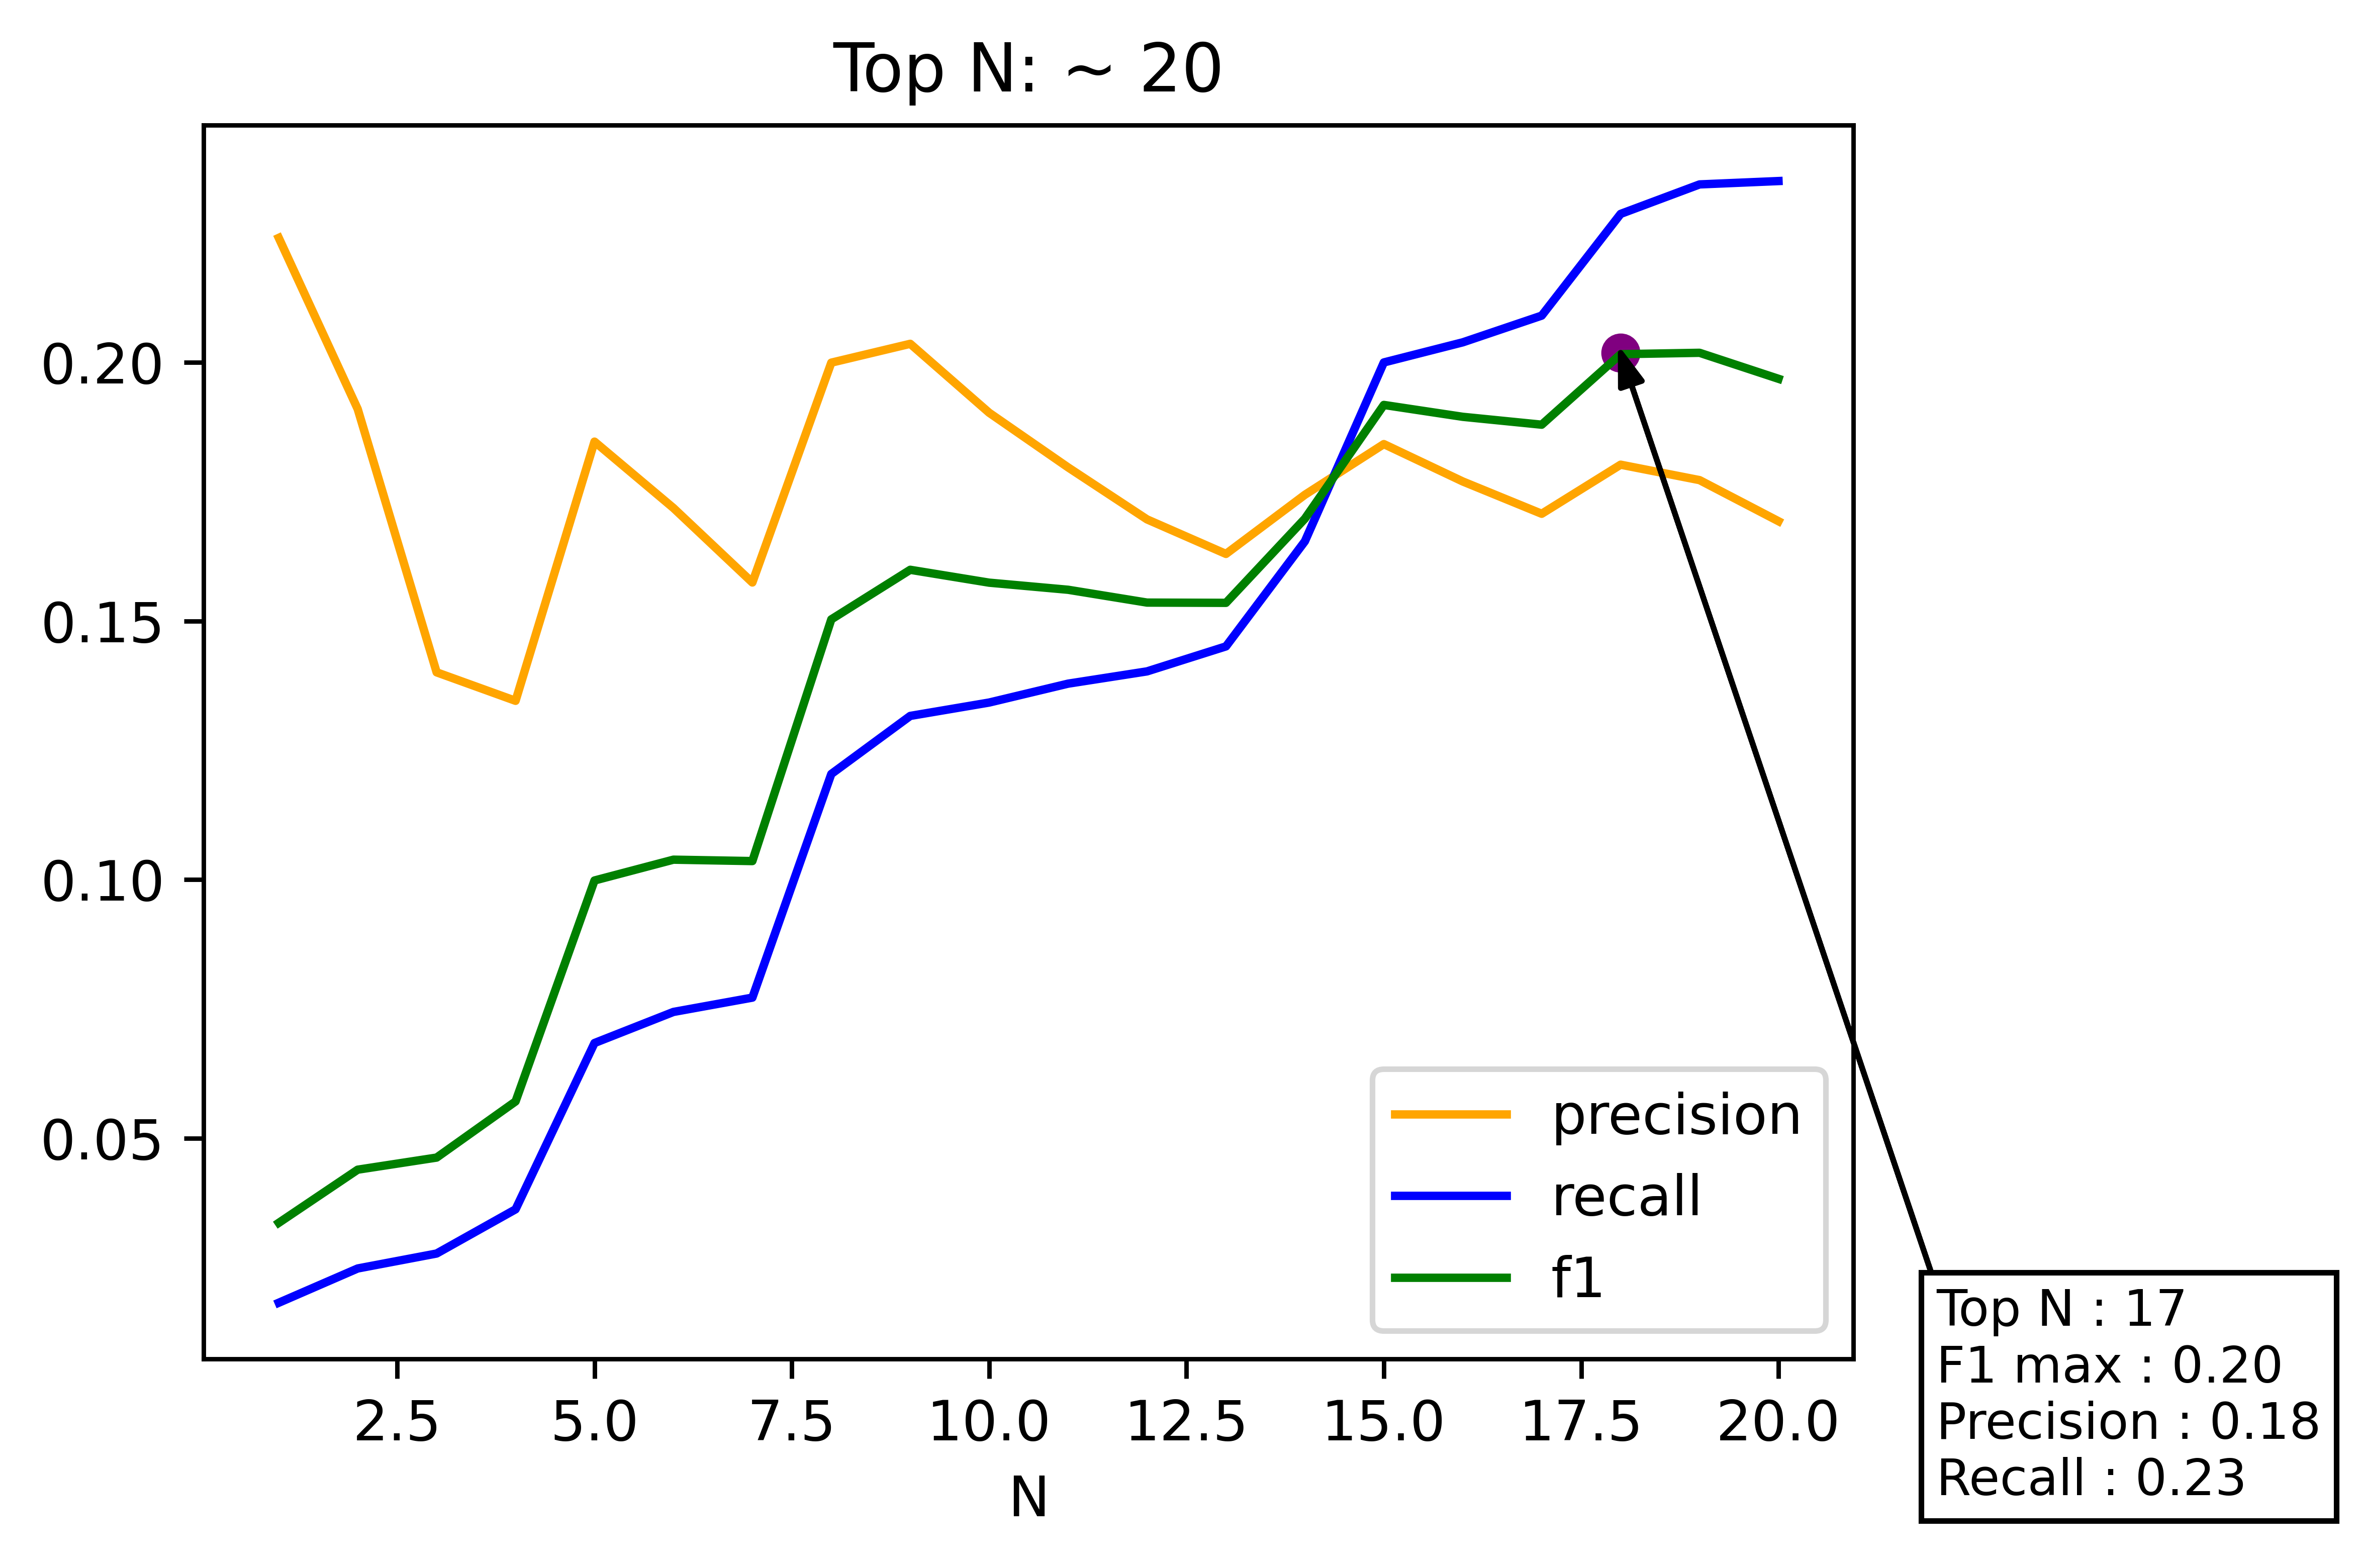

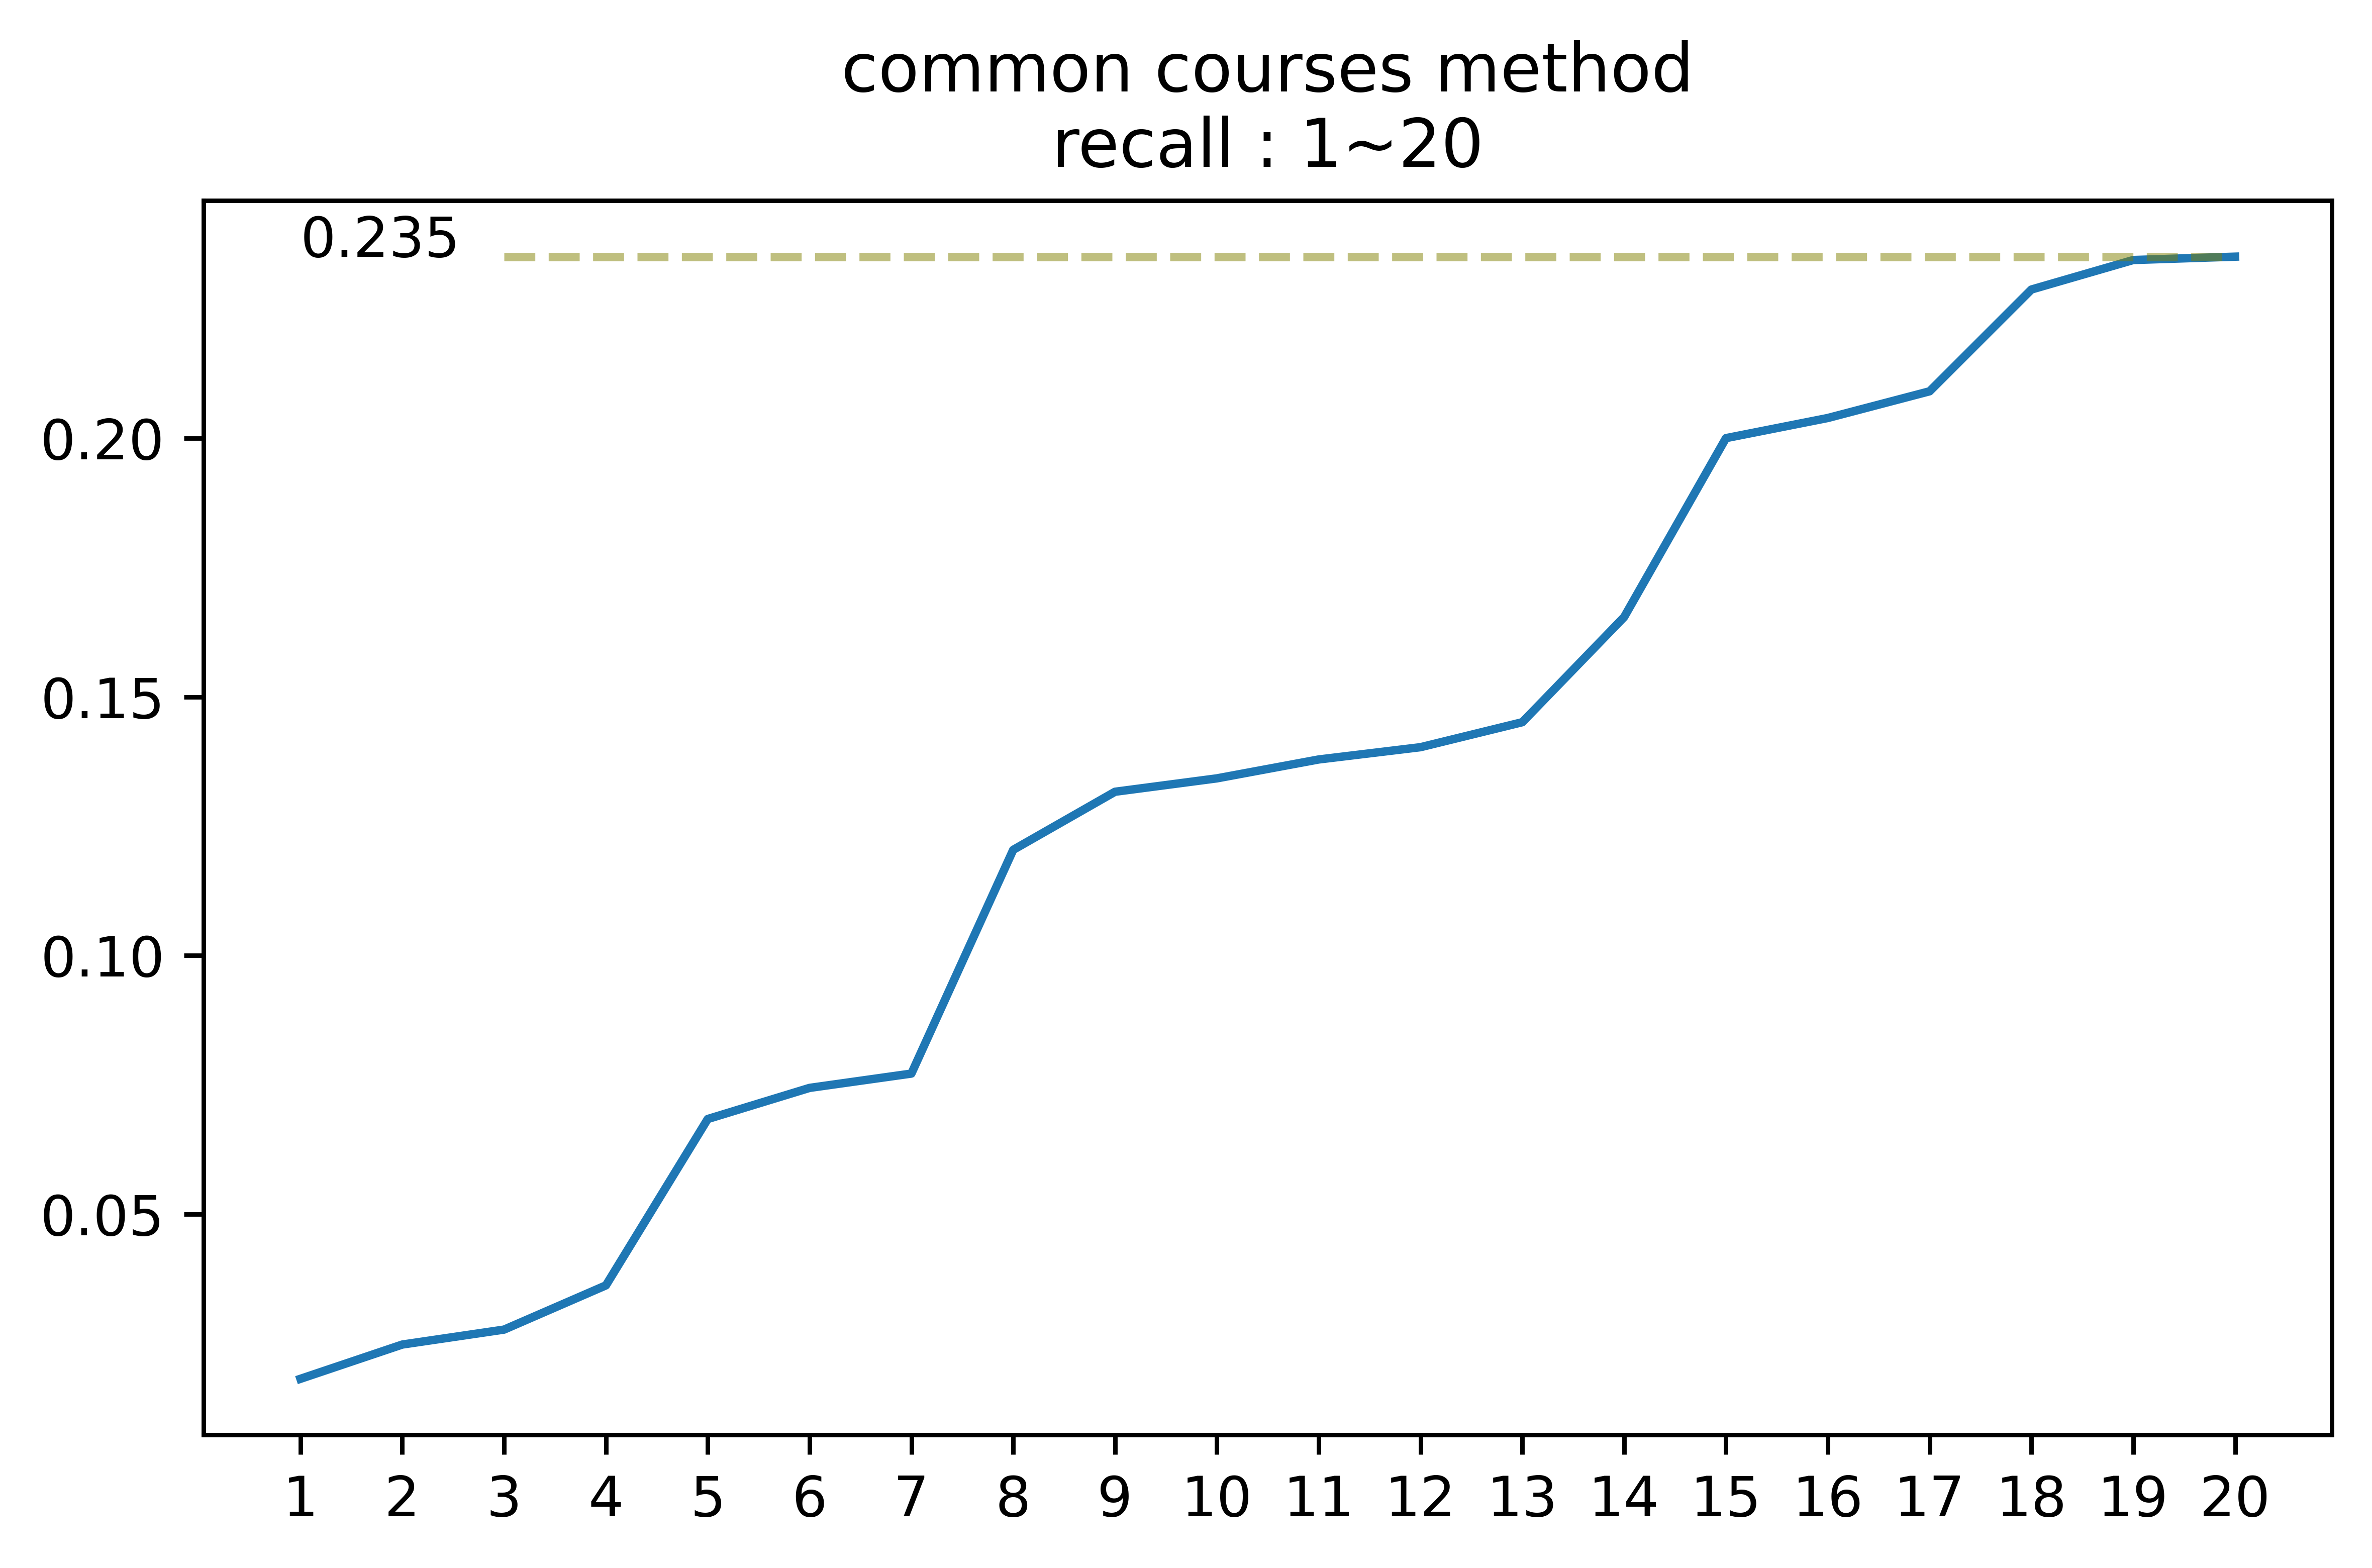

In [6]:
topk = 20
metrics = loadjson(
    os.path.join(popular_savepath,"metrics", "metrics.json")
)

zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(popular_savepath,"metrics"),
    showinline=True
)

## METHOD1
Using all courses that a user have had taken.  



In [4]:
%autoreload
from RS.commoncourse import \
    recommend_according_course_selection_records

In [5]:
commoncourse_savepath = os.path.join("result", "commoncourse")
if not os.path.exists(commoncourse_savepath):
    print(f"mkdir : {commoncourse_savepath}")
    os.mkdir(commoncourse_savepath)

### Steps:

1. __Generate__ $M_{category \times course}$

  - Input:
    - $M_{u_\text{train} \times category}$ : 
      - each entry $(u_j, cate_i)$ means the counts of category $cate_i$ being lended  by the trained-user $u_{j}$
    - $M_{u_{\text{train}} \times course}$ :
      - each entry $(u_j,course_k)$ means whether the trained-user $u_j$ had taken the course $course_k$. It is a binary matrix.

  - Output : 
    - $M_{category \times {course}}$: 
      - each entry of it means the mean counts of $category_i$ lended by the training students who had taken $course_j$.

  - Steps:
    1. $M_{norm, u_\text{train}\times course} := $ normalize $M_{u_\text{{train}} \times course}$ along it's column by $L_1$ norm.

    2. $M_{category \times {course}} \gets M_{u_\text{{train}} \times category}^T \times  M_{norm, u_\text{{train}}\times course}$

    3. return  $M_{category \times {course}}$

2. Generate recommend list: 

    $\textbf{for}$ each ${u_{\text{test}_\text{t}}}\in $ testing users:

  - Input (from step 1. directly):
    - $M_{ij}$: 
      - Mean counts of $\text{category}_i$ lended by the training students who had taken $\text{course}_j$. 

    - $Course_{u_{\text{test}_\text{t}}}$: 
      - $\{course_{i} \textbf{ }| \textbf{ } course_{i} \in$  course selection records of  ${u_{\text{test}_\text{t}}} \}$.
    - $topN$: 
      - top-N categories needed to be recommended.
  - Output : 
    - topN Recommend categories for a cold-started user ${u_{\text{test}_\text{t}}}$

  - Steps :
    1. __initialize__ : $CategoryCount_{{u_{\text{test}_\text{t}}}} := [0]_{1 \times |categories|}$

    2. For {$category_i$ $\in$ all categories}
      - $CategoryCount_{u_{\text{test}_\text{t}}}[category_i] \gets \frac{ \displaystyle\sum_{course_j\in Course_{u_{\text{test}_\text{t}}}} M[category_i][course_j]}{|Course_{u_{\text{test}_\text{t}}}|}$

    3. return category indices of $topN$ maximum values of $CategoryCount_{u_{\text{test}_\text{t}}}$

In [6]:
rslist_saving_path = recommend_according_course_selection_records(
    dataset=dataset, resultroot=commoncourse_savepath, d=d
)

build book x user .. OK ..
prediction ..


100%|██████████| 1254/1254 [00:00<00:00, 1488.76it/s]


OK .. save at result/commoncourse/recommendlist.json


### Evaluation

In [7]:
rslist_saving_path=os.path.join(
    commoncourse_savepath, "recommendlist.json"
)

Evaluate(
    result_root=commoncourse_savepath, 
    recommendlist = rslist_saving_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates
)

result/commoncourse/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:54<00:00,  1.19s/it]


Precision_Recall_F1 : result/commoncourse/metrics/metrics.jpg
PR : result/commoncourse/metrics/PR.jpg
ROC : result/commoncourse/metrics/ROC.jpg


#### Zoom-in top k

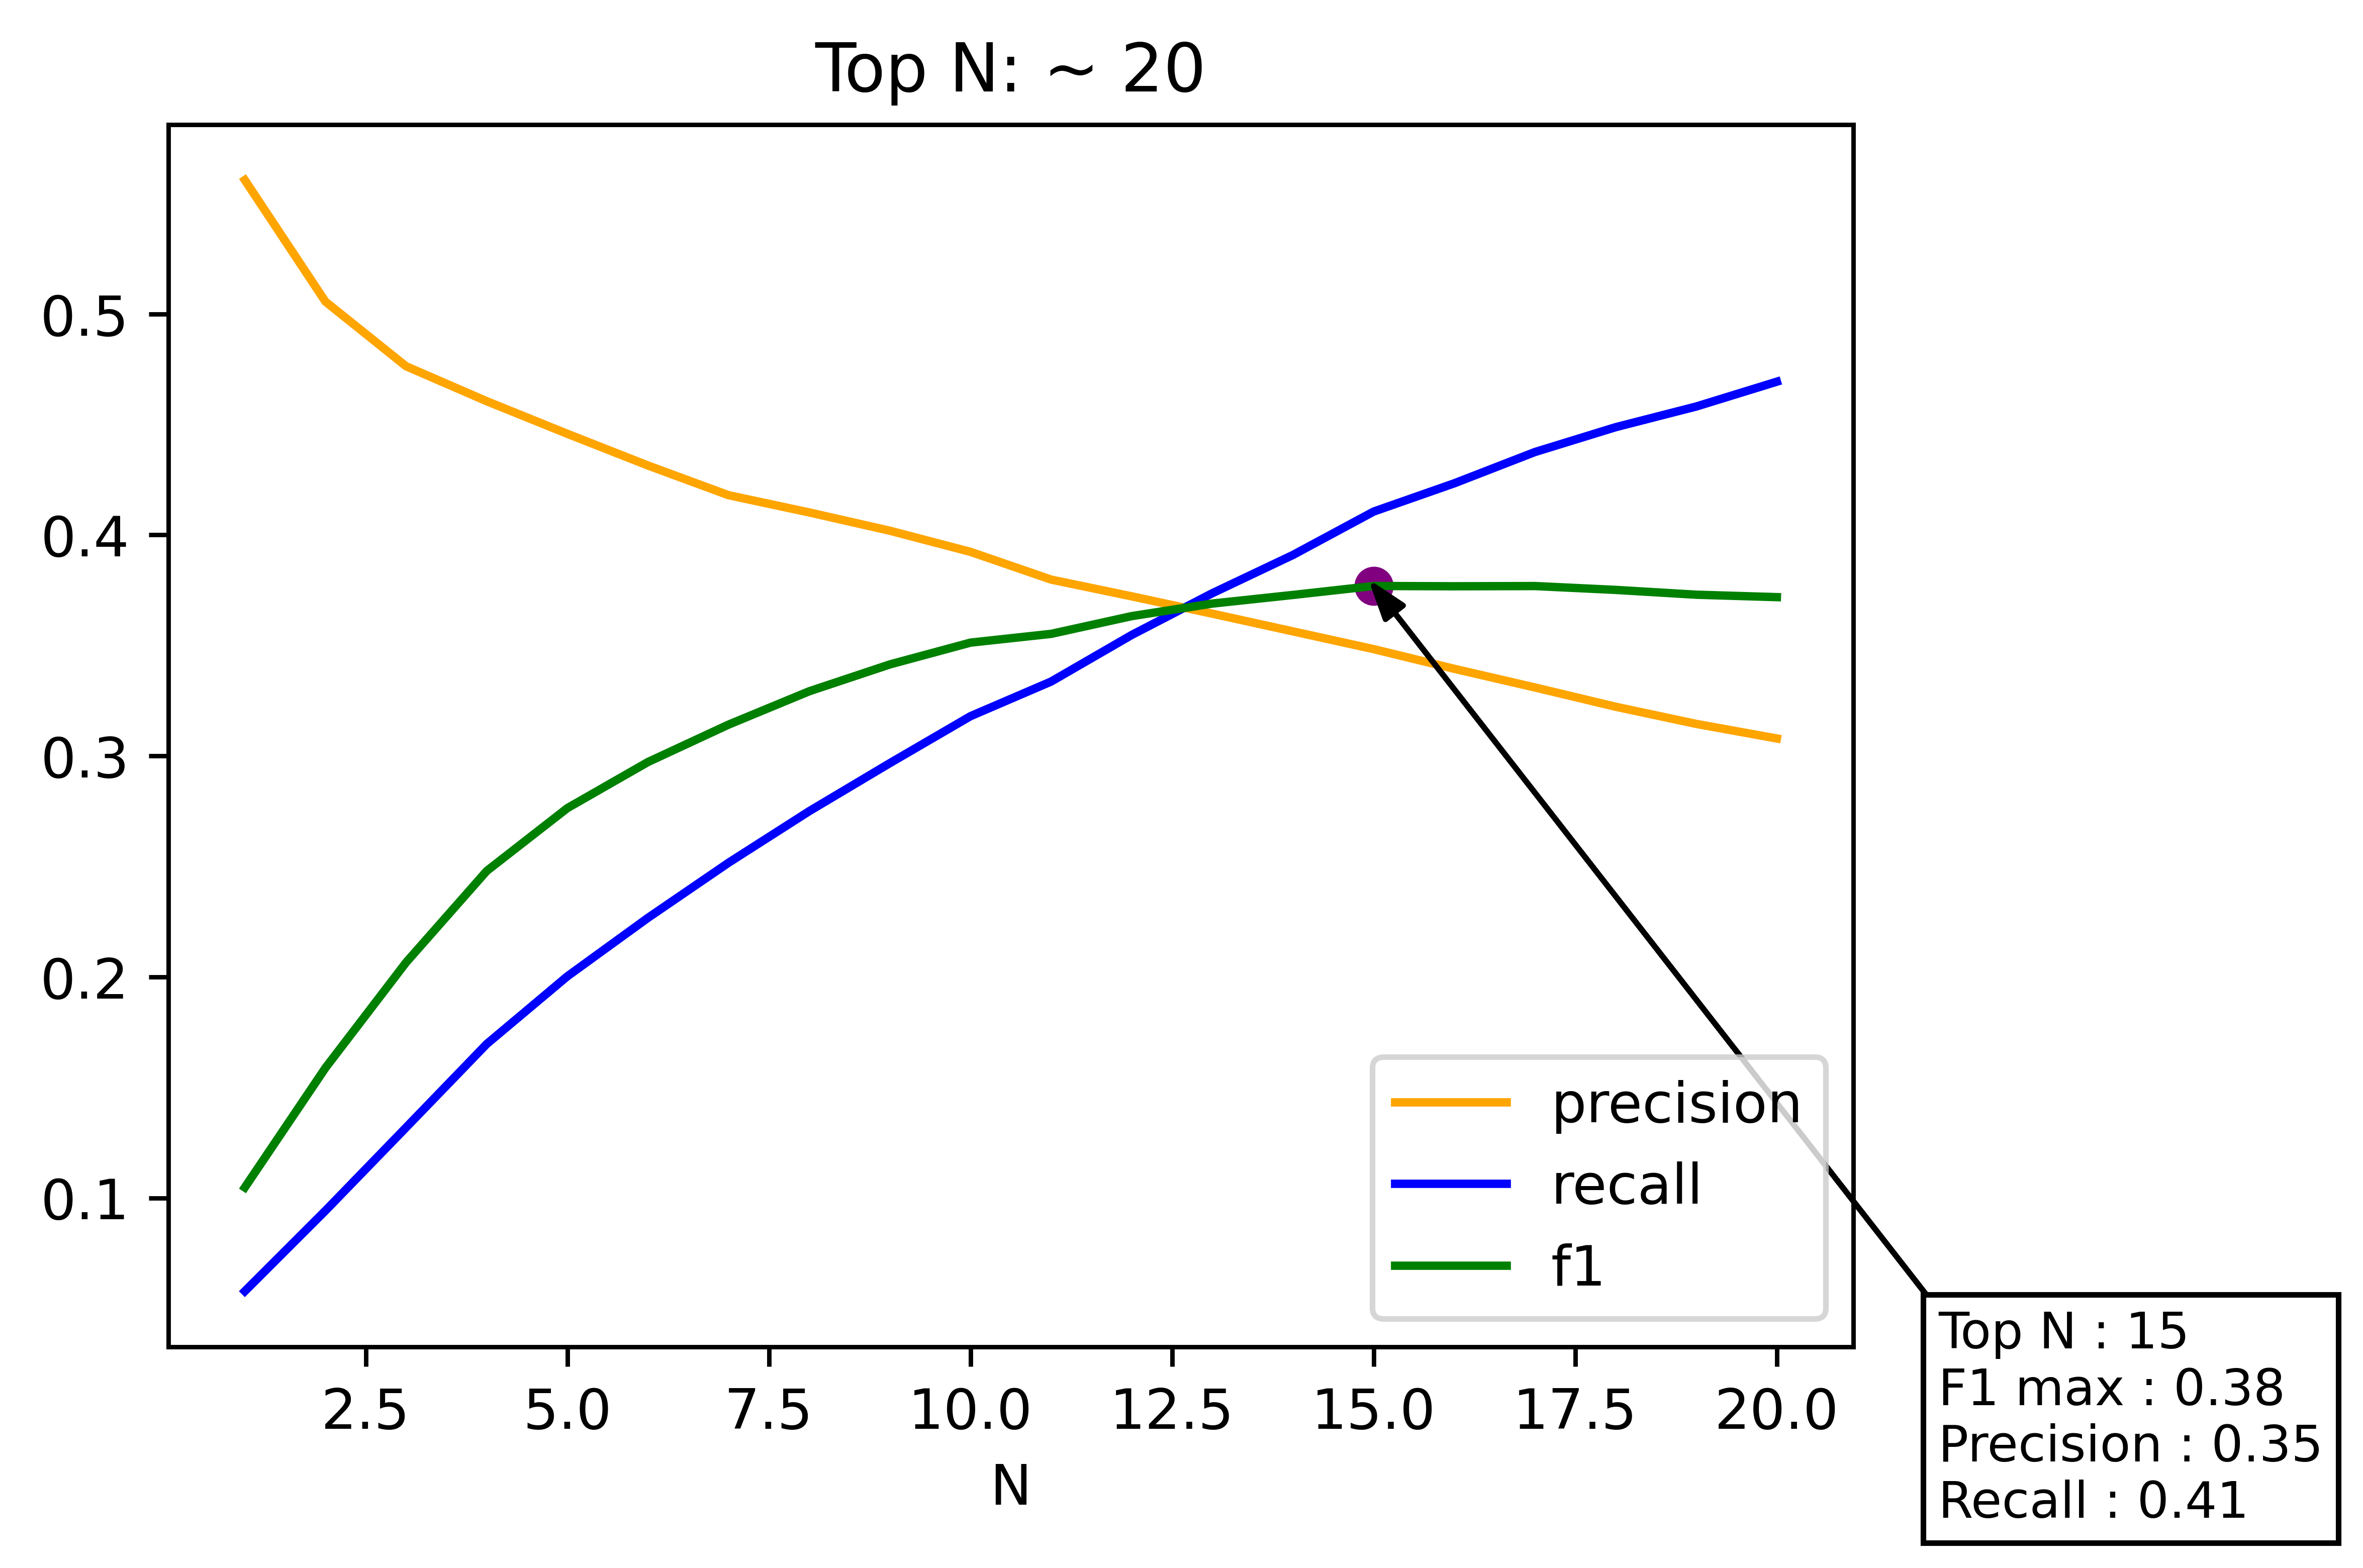

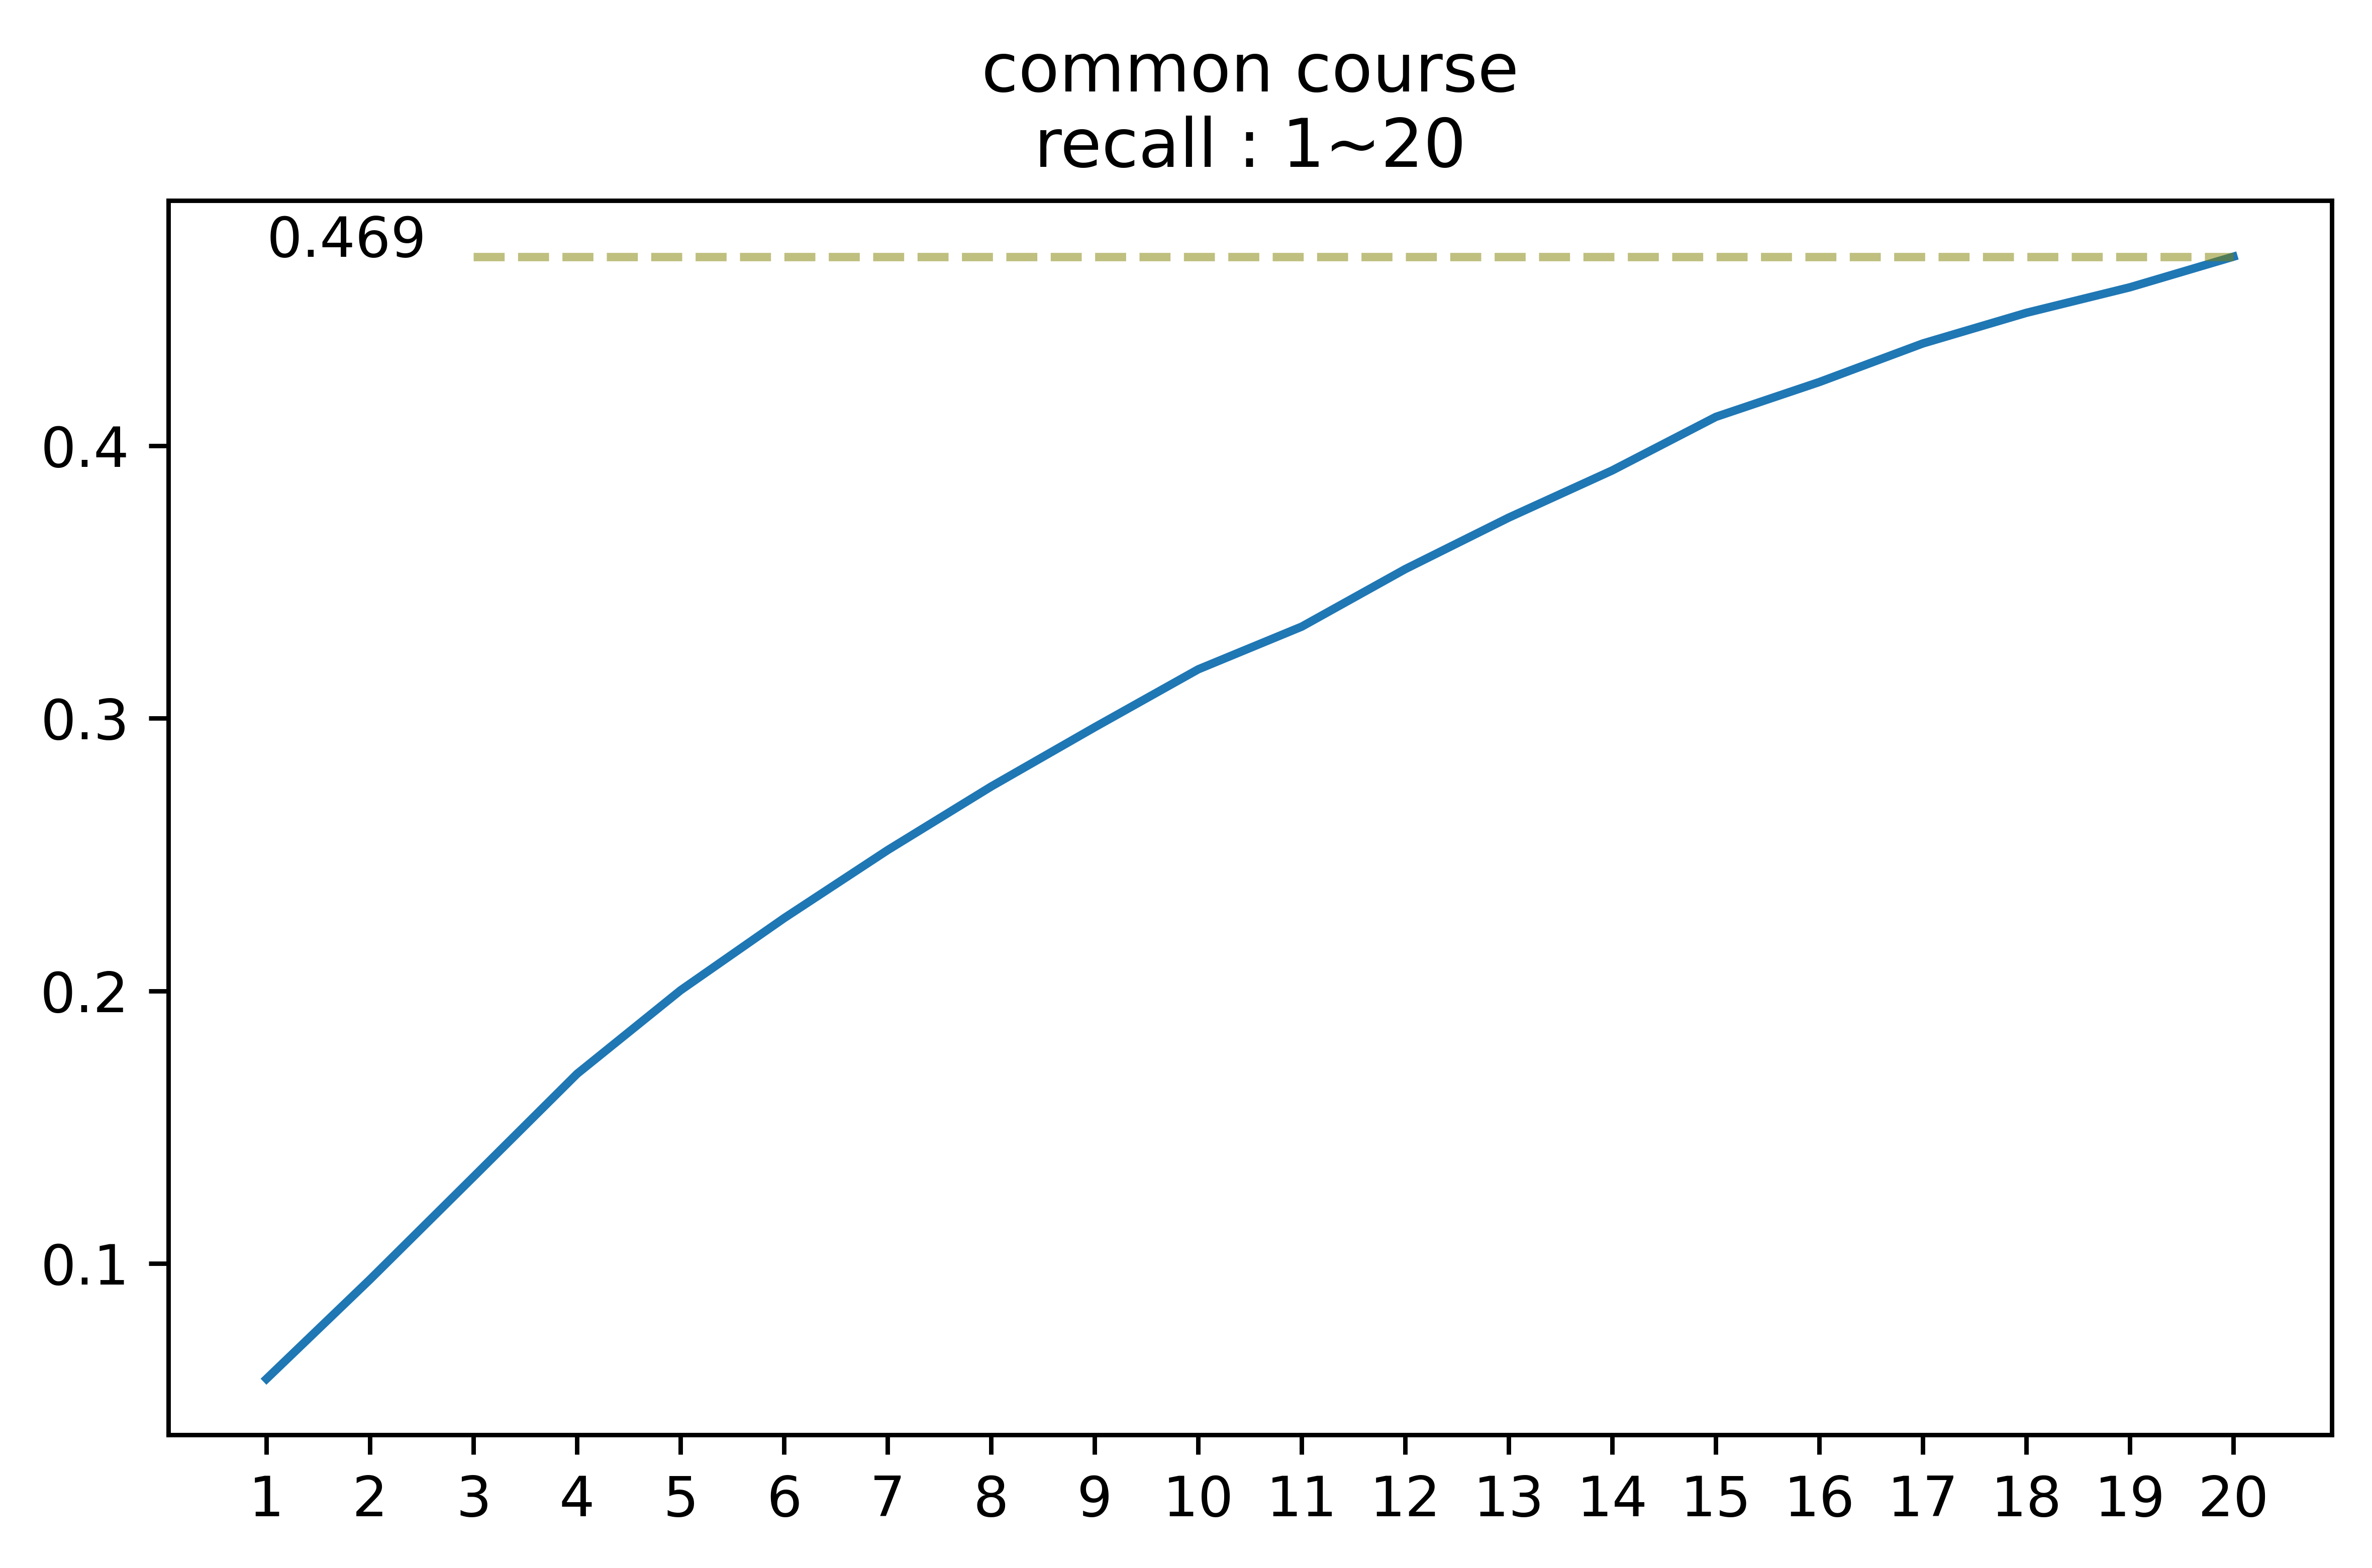

In [9]:
topk = 20
metrics = loadjson(
    os.path.join(
        commoncourse_savepath,"metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(commoncourse_savepath,"metrics"),
    showinline=True,
    title="common course"
)


### Regularization by using the result of association rule

In [51]:
from apyori import apriori

In [ ]:
training_records = dataset.getdata(
    dataname="training_user_book"
).drop(columns=['uid'])
training_records.head()

In [20]:
training_records_savepath = os.path.join(
    ".","data","book","association","transaction_L3.json"
)

In [17]:
training_records_2dlist = []
for tui in tqdm(training_records.values):
    ri=(np.argwhere(tui > 0))
    training_records_2dlist.append(
        list(map(lambda i:str(i), ri.T[0].tolist()))
    )
print(training_records_2dlist[:3])
writejson(
    dictionary=training_records_2dlist,
    jsfilepath=training_records_savepath
)

100%|██████████| 20575/20575 [00:00<00:00, 40742.60it/s]

[['90', '121', '844', '857', '947'], ['122', '610', '623', '624', '782', '821'], ['805', '813', '820', '857', '873', '880']]


In [52]:
training_records_2dlist = loadjson(
    os.path.join(".","data","book","association","transaction_L3.json")
)

In [60]:
rules = list(
    apriori(
        transactions=training_records_2dlist,
        min_support=0.09, 
        min_confidence=0.6, 
        min_lift=1.01, max_length=2
    )
)
print(len(rules))
r = []
for p in rules:
    pair= p[0]
    if len(pair)>1:
        r.append([x for x in pair])

writejson(
    r, os.path.join("data","book","association","rules.json")
)

9


In [30]:
origin_recommend_list = loadjson(
    os.path.join(commoncourse_savepath,"recommendlist.json"),
)
r = loadjson(
    os.path.join("data","book","association","rules.json")
)

In [ ]:
reg_rslist = {}
pbar = tqdm(
    origin_recommend_list.items(), 
    total=len(origin_recommend_list)
)

for uid, c in pbar:
    reg_rec_i = []
    for idx, ci in enumerate(c):
        if ci not in reg_rec_i:
            reg_rec_i.append(ci)
            for rulei in r:
                if ci in rulei:
                    for ri in rulei:
                        if ri not in reg_rec_i:
                            reg_rec_i.append(ri)
        pbar.set_postfix(ordered_dict={'catei':idx})
    reg_rslist[uid] = reg_rec_i


writejson(
    reg_rslist, 
    os.path.join(commoncourse_savepath,"recommendlist_ass.json")
)

In [ ]:
Evaluate(
    result_root= os.path.join(commoncourse_savepath,"ass_reg"), 
    recommendlist = os.path.join(commoncourse_savepath,"recommendlist_ass.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates,
    topN_range=30
)

result/commoncourse/ass_reg/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Precision_Recall_F1 : result/commoncourse/ass_reg/metrics/metrics.jpg
PR : result/commoncourse/ass_reg/metrics/PR.jpg
ROC : result/commoncourse/ass_reg/metrics/ROC.jpg


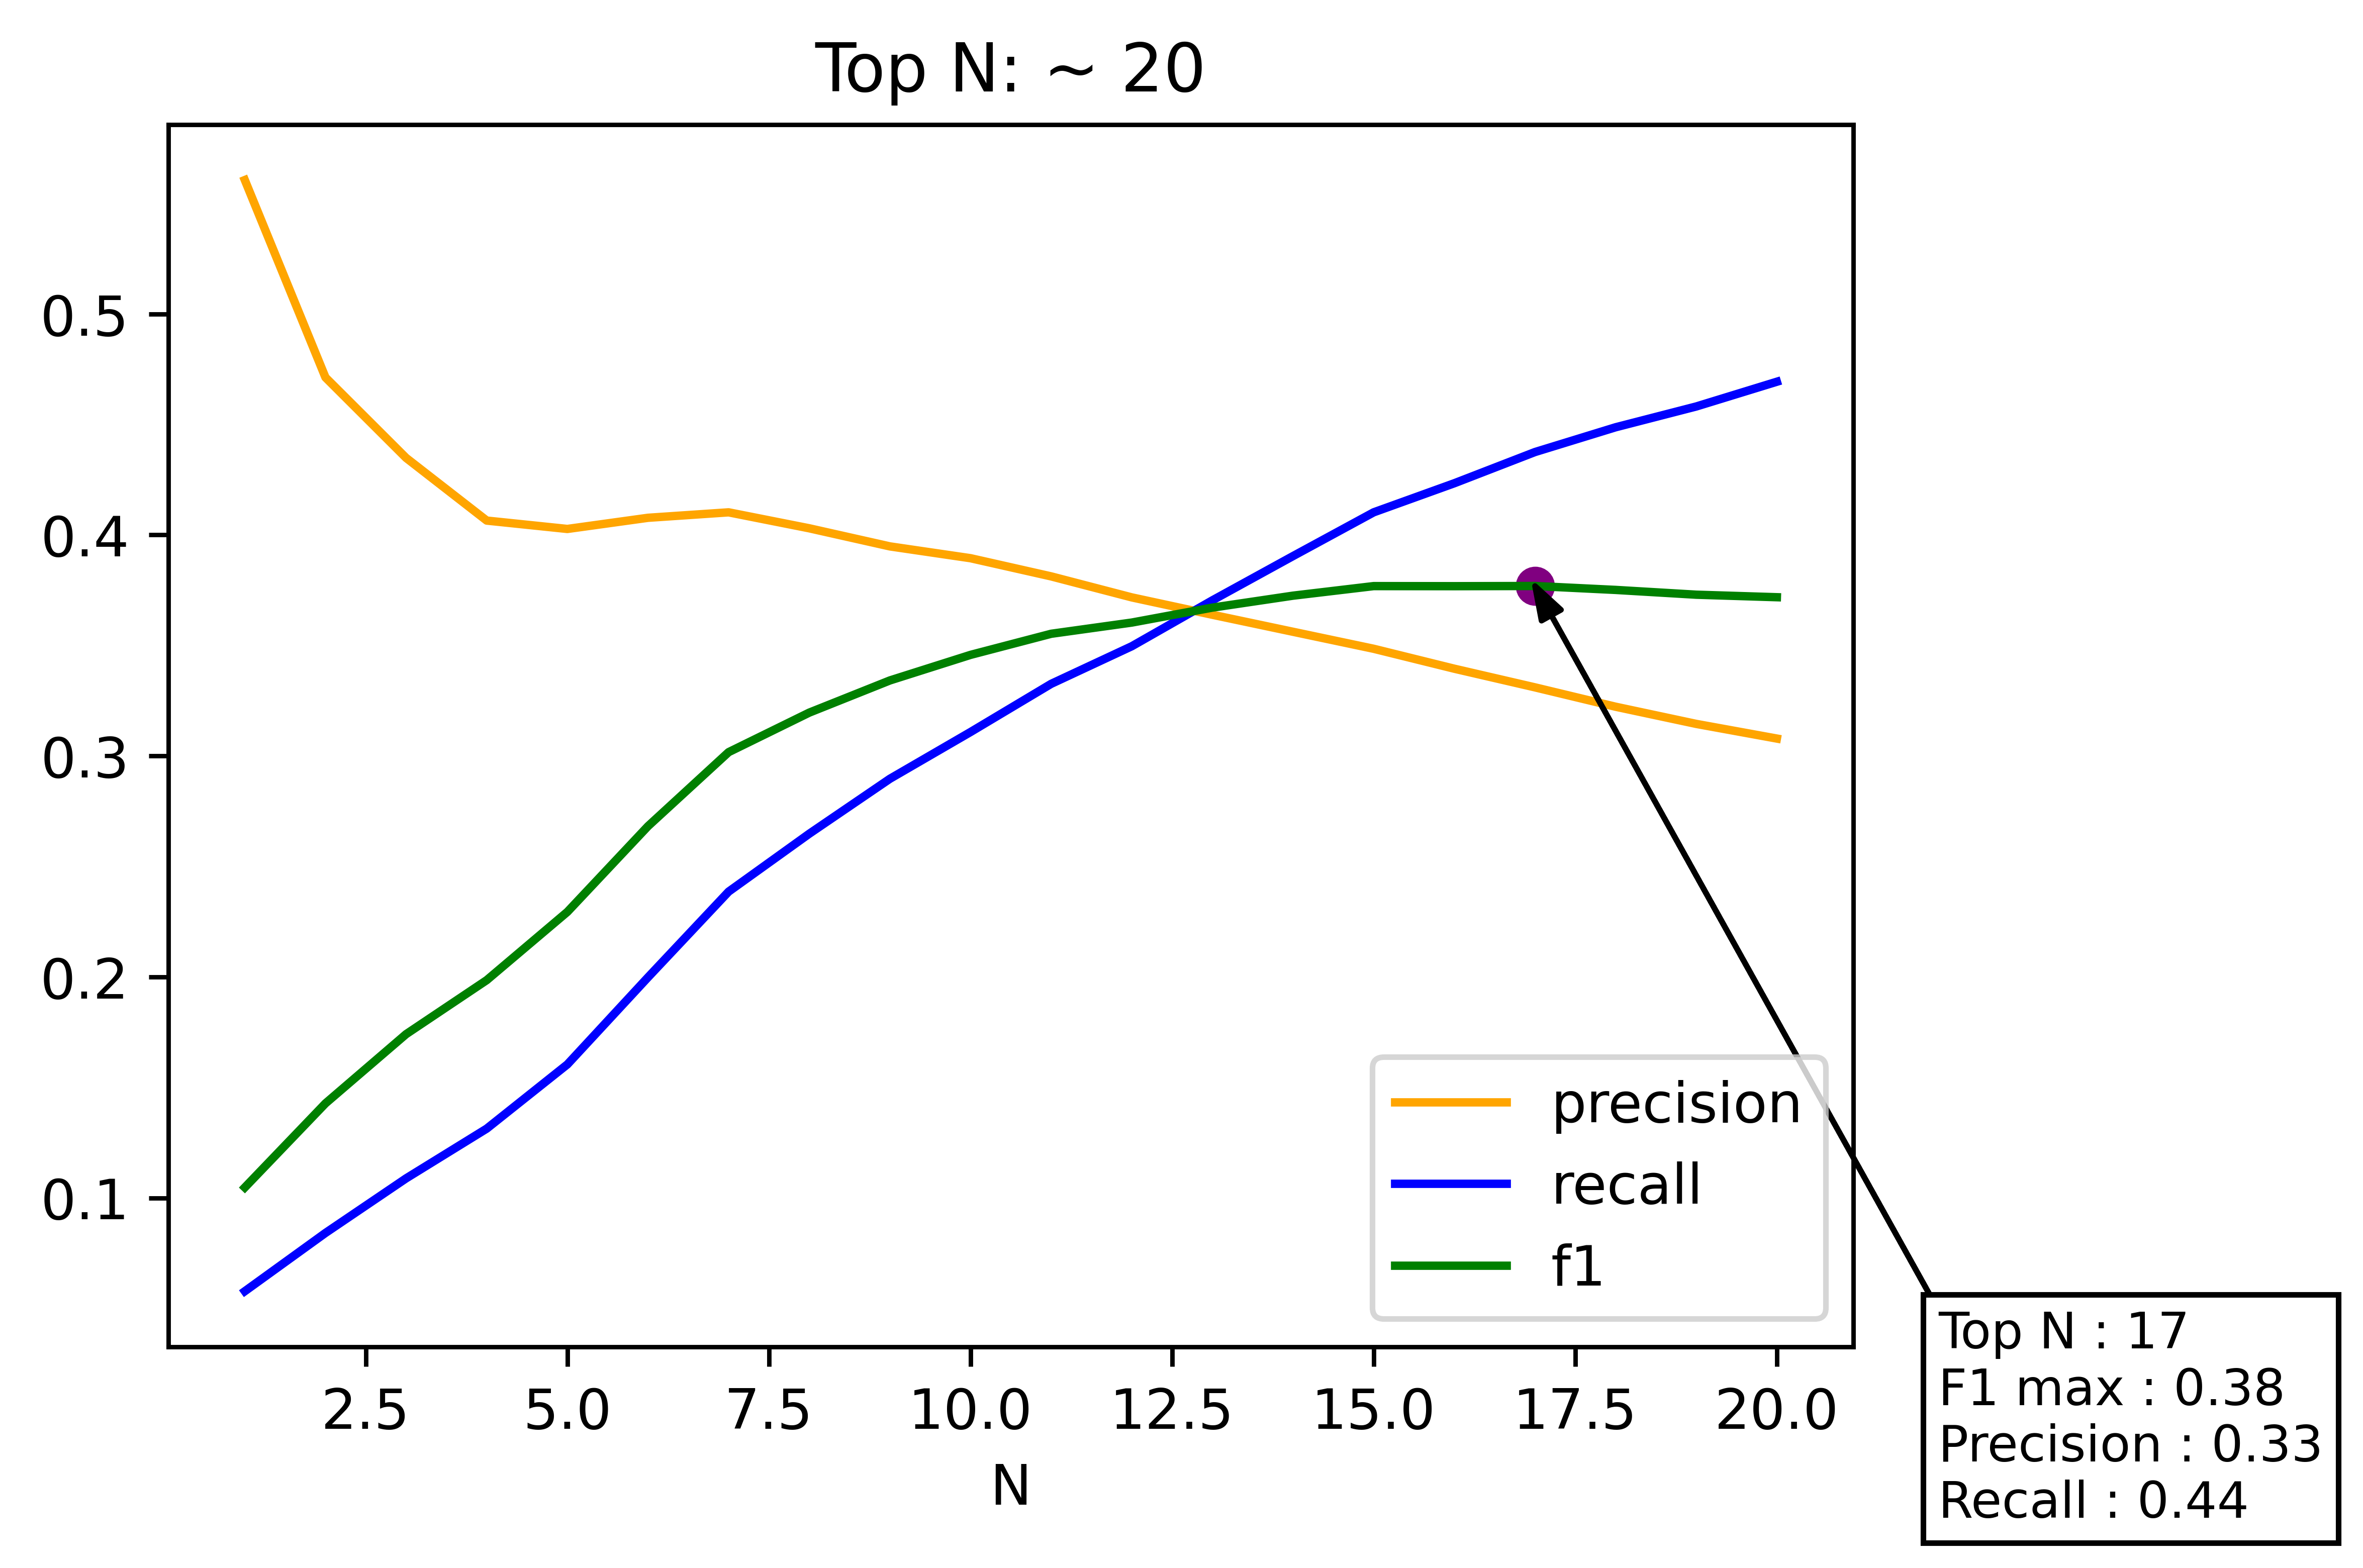

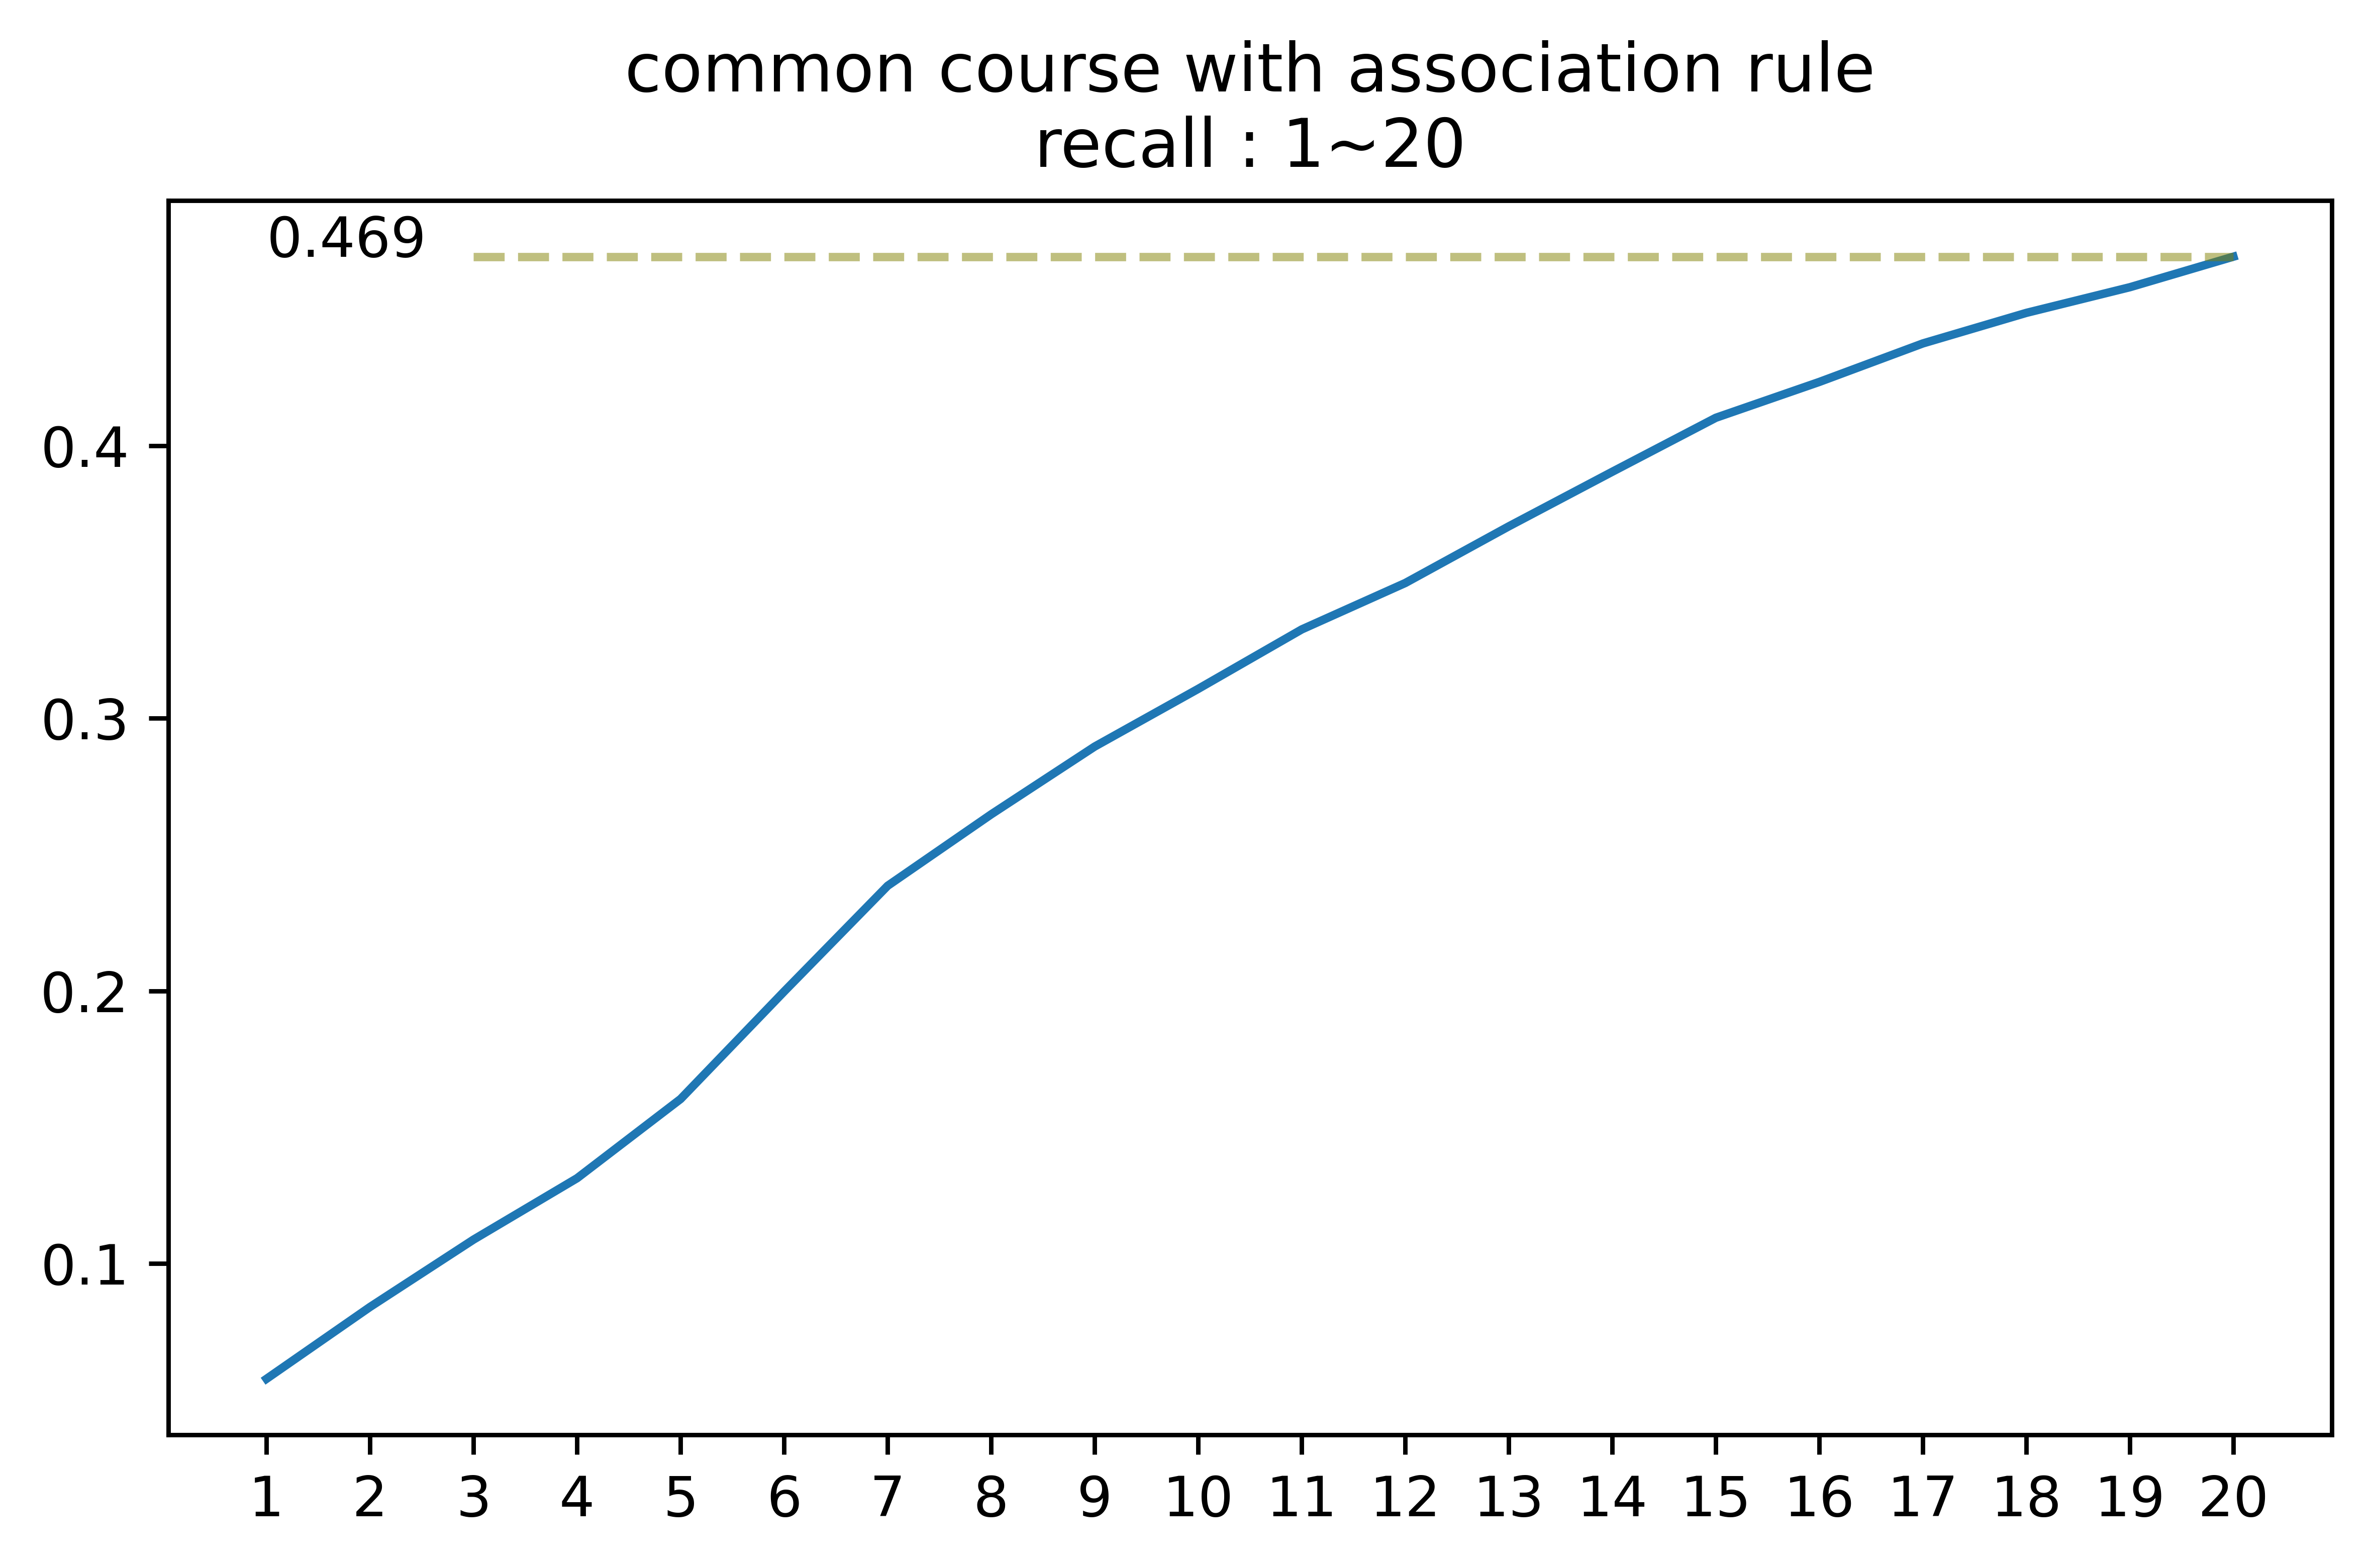

In [7]:
topk = 20
metrics = loadjson(
    os.path.join(
        commoncourse_savepath,
        "diff_min_support", "9","metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(
        commoncourse_savepath,
        "diff_min_support","9","metrics"
    ),
    showinline=True,
    title="common course with association rule"
)

## METHOD 2

CBMF

- reference: 
  - __Improving Top-N Recommendation for Cold-Start Users via Cross-Domain Information__
  - Authors: 
    Nima Mirbakhsh, Charles X. Ling
    
  - ACM Transactions on Knowledge Discovery from DataVolume 9Issue 4June 2015

In [4]:
cbmf_savepath = os.path.join("result", "CBMF")
if not os.path.exists(cbmf_savepath):
    print(f"mkdir : {cbmf_savepath}")
    os.mkdir(cbmf_savepath)
    os.mkdir(os.path.join(cbmf_savepath, "metrics"))

In [5]:
%autoreload
from RS.mf_based import Cross_MF
from RS.utils.mf import WeightedALS_MF
from RS.utils.plotutils import plotLoss

#### Build Cross Domain user item matrix

In [6]:
%autoreload
from RS.utils.dataset import build_cross_domain_matrix

$$\begin{bmatrix}
&|&\text{book}_1&\text{book}_2&...&|&\text{course}_1&\text{course}_2&...\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{train}_1}&|&&&&|\\
u_{\text{train}_2}&|&&&&|\\
...&|&&&&|\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{test}_1}&|&&&&|\\
u_{\text{test}_1}&|&&&&|\\
...&|&&&&|\\
\end{bmatrix}$$

In [7]:
info, cross_matrix = build_cross_domain_matrix(
    dataset=dataset,
    domains=[
        [   
            ("training_user_book",False,True),
            ("testing_user_book",True,False)
        ],
        [
            ("training_user_course", False, False),
            ("testing_user_course",False,False)
        ]
    ],
    savedir=os.path.join(dataroot, "crossdomain", "origin"),
    return_data="torch"  
)

name : training_user_book, mask: False, normalization: True
    normalization along row : True
name : testing_user_book, mask: True, normalization: False
     mask up
name : training_user_course, mask: False, normalization: False
    normalization along row : False
name : testing_user_course, mask: False, normalization: False
    normalization along row : False
save cross domain df to : data/crossdomain/origin/cross_domain.csv
save cross domain matrix to : data/crossdomain/origin/cross_domain


### Non Clustering 

#### MF

In [21]:
# for halfway execution
# If continuously execute from
# Build Cross Domain user item matrix,
# There is no needed to execute this block

cross_matrix = torch.tensor(
    np.load(
        os.path.join(dataroot, "crossdomain",
        "normalize","cross_domain.npy"
        )
    ),
    dtype=torch.double
)

info = loadjson(
    os.path.join(dataroot, "crossdomain","normalize","info.json")
)

In [25]:
mf_args = {
    'latency':40,'l2_reg':0.7,
    'fill_empty':torch.mean(cross_matrix).item(),
    'w_obs':1, 'w_m':0.001,
    'epochs':3
}

sp = os.path.join(cbmf_savepath,"nonclustering","normalize")
modelsp = os.path.join(sp, "model")
recommend_list_path = Cross_MF(
    cross_matrix=cross_matrix,
    testing_range=info['testing_range'],
    testing_user=info['testing_user'],
    model="WeightedALS_MF", model_args=mf_args,
    on_device=d,model_save_path=modelsp,
    result_saving_path=sp,show_loss=False
)

MF .. 
WeightedALS_MF
random loss: 102.22463464891383


100%|██████████| 3/3 [05:42<00:00, 114.23s/it, currentbest=0.004, mse=0.004, improve=0.0000, early=1]  


MF done ..
generate recommend list ..


100%|██████████| 1254/1254 [00:00<00:00, 3070.99it/s]


done .., recommend list is at result/CBMF/nonclustering/normalize/recommendlist.json


#### Evaluation

In [89]:
# for halfway execution
# If continuously execute from
# MF,
# There is no needed to execute this block

recommend_list_path=os.path.join(
    cbmf_savepath,"nonclustering",
    "normalize","recommendlist.json"
)

In [ ]:
Evaluate(
    result_root = os.path.join(cbmf_savepath, "nonclustering","normalize"), 
    recommendlist = recommend_list_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates
)

##### Zoom in top-k

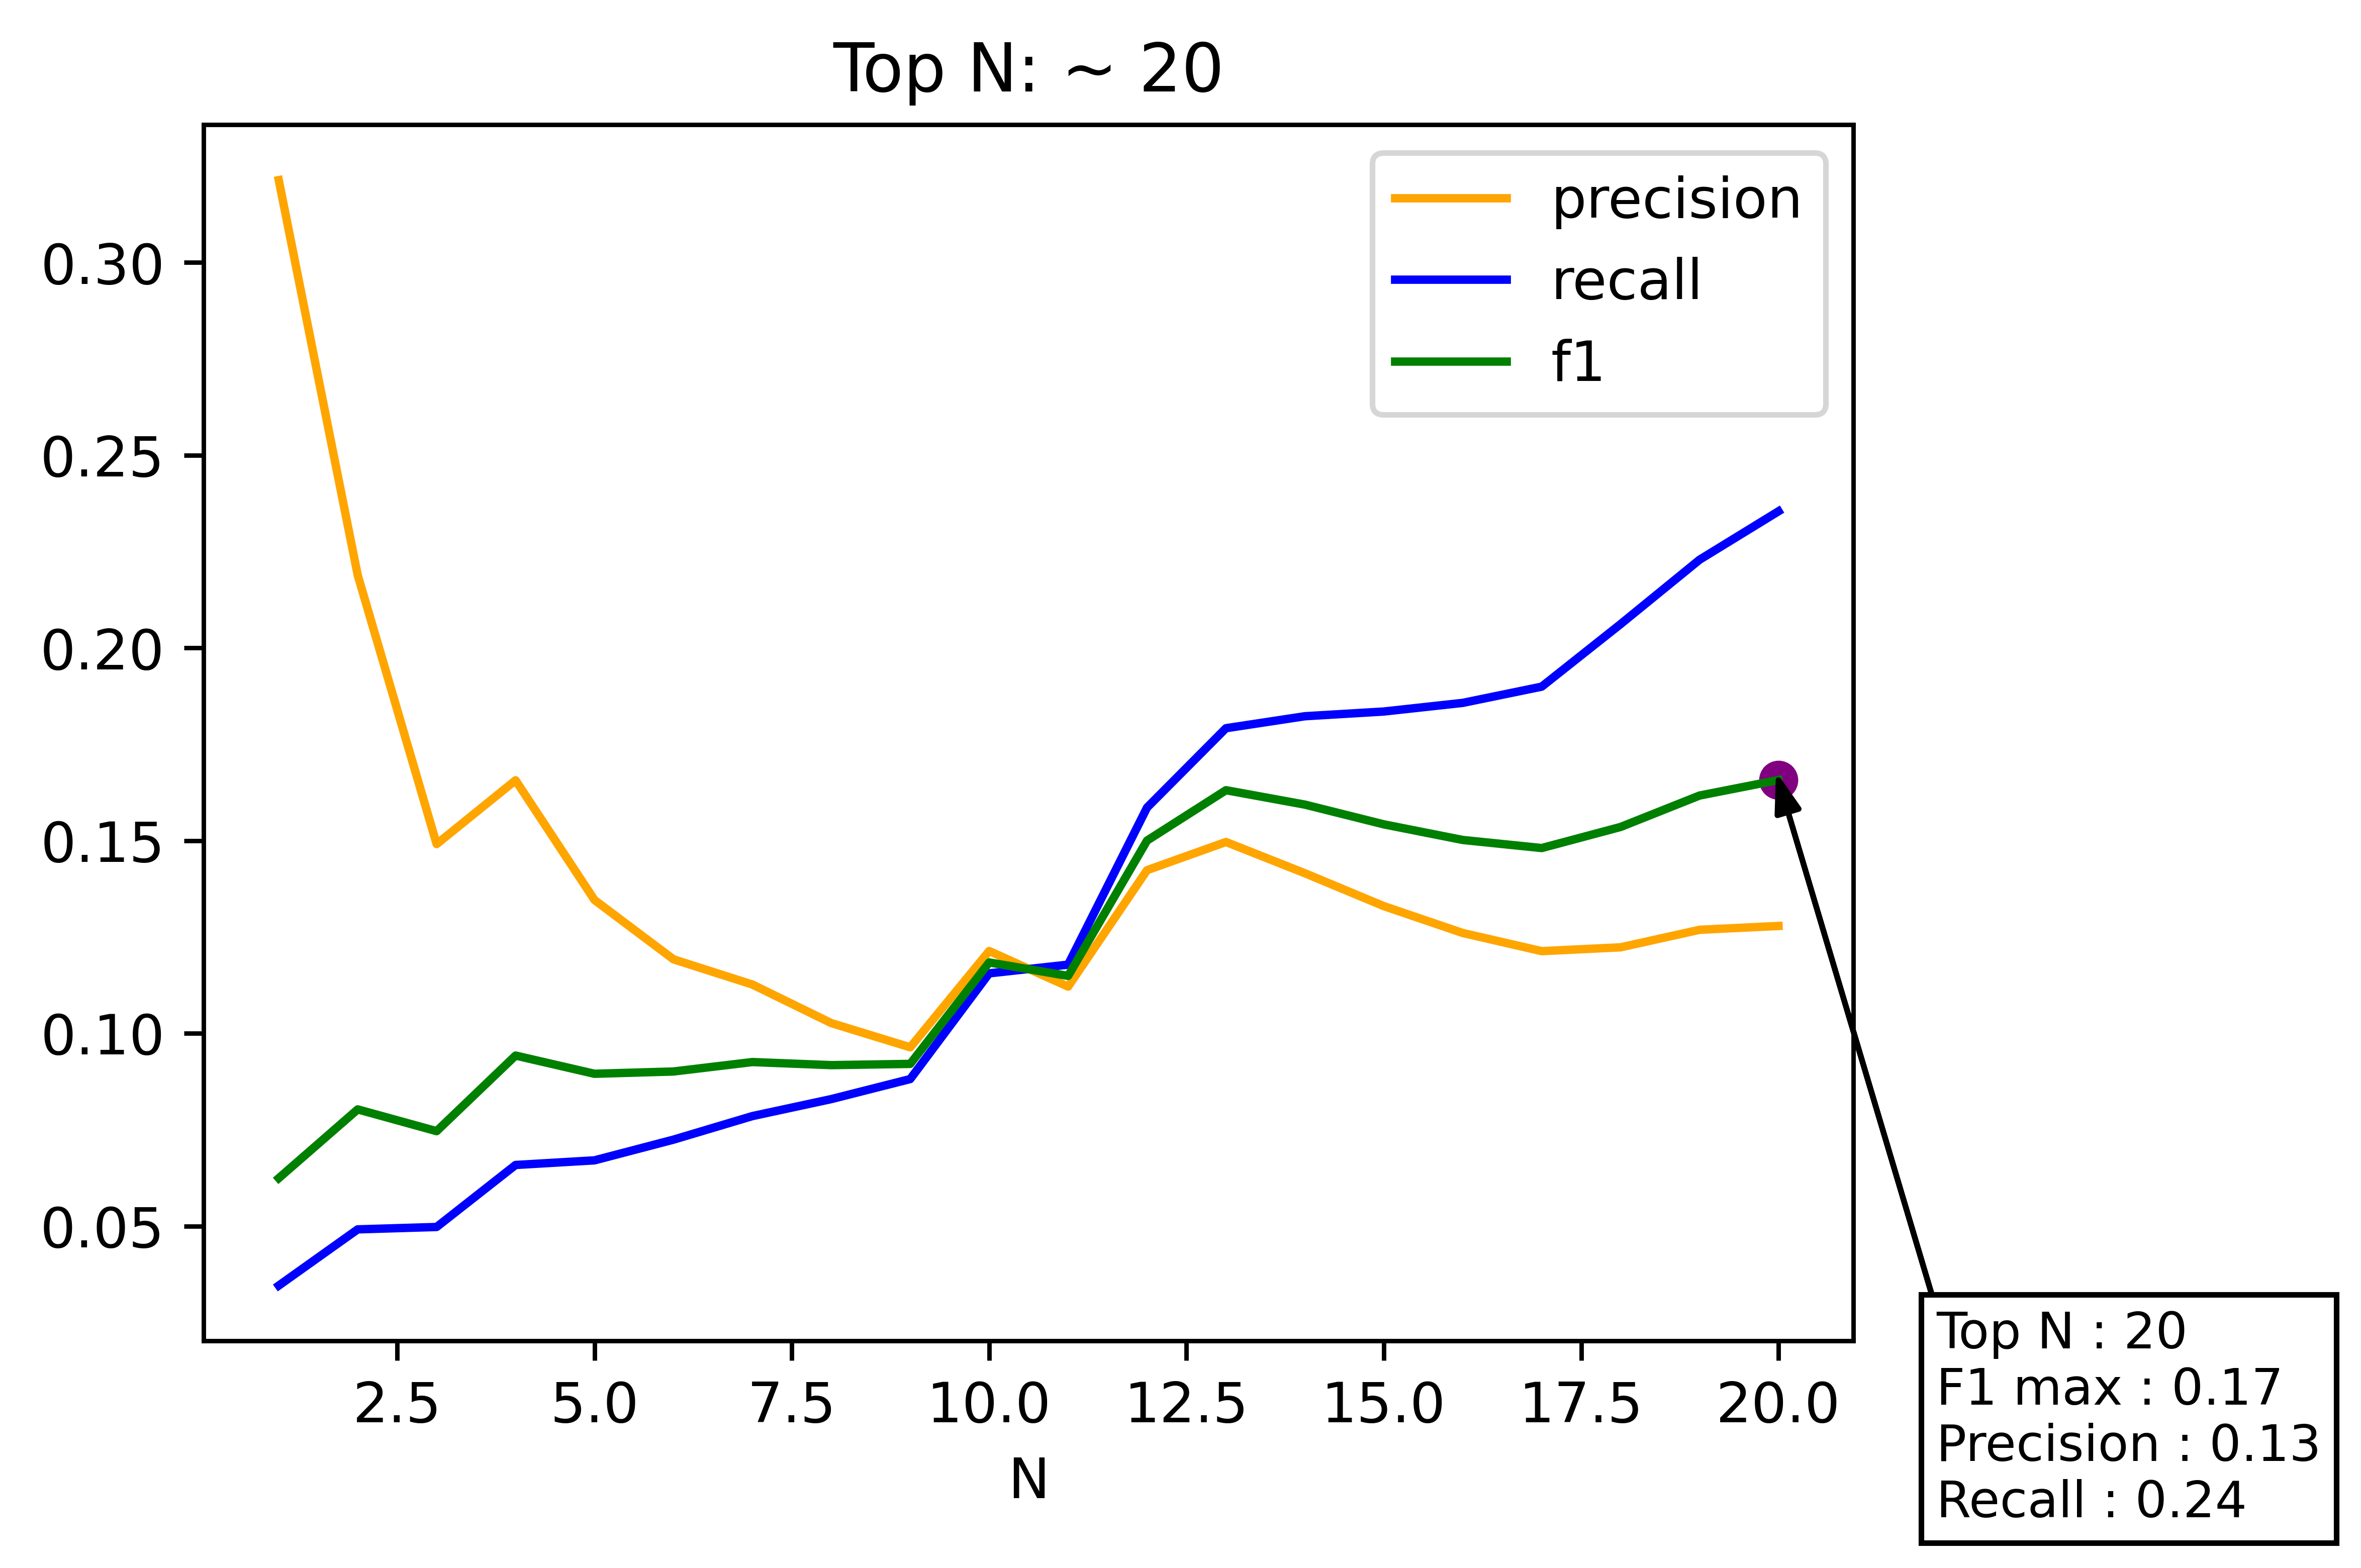

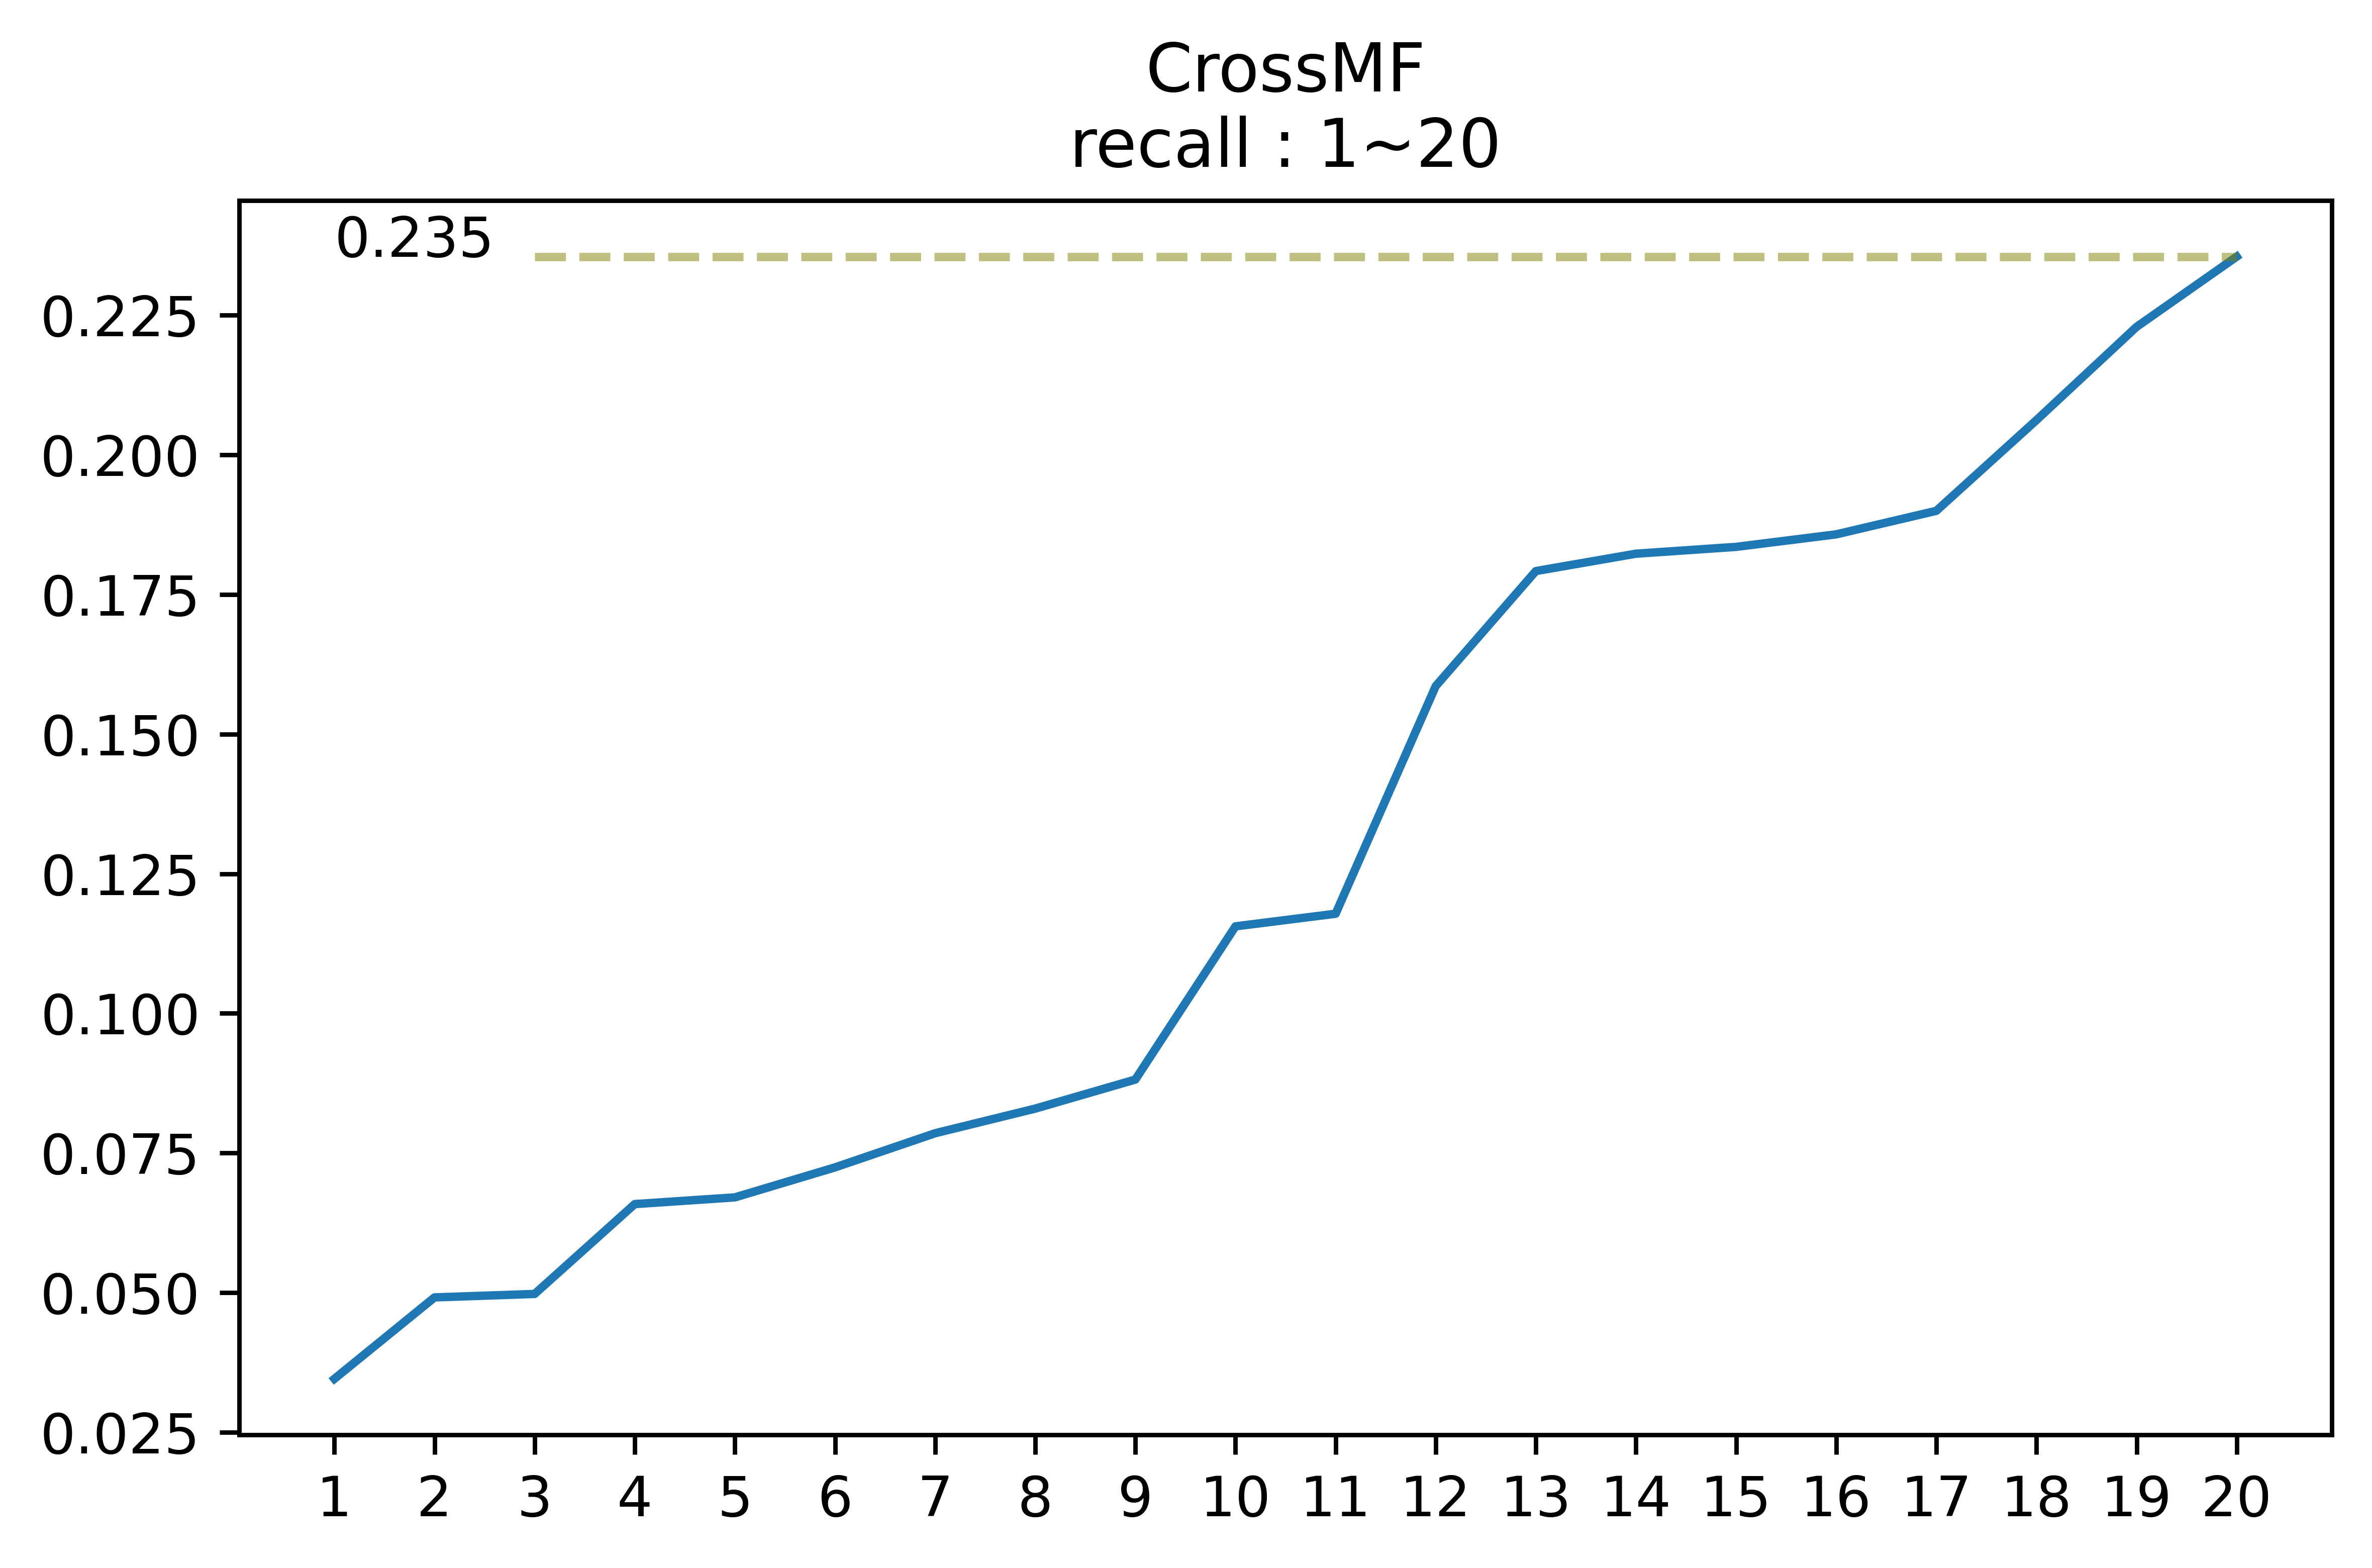

In [5]:
topk = 20
metrics = loadjson(
    os.path.join(
        cbmf_savepath,"nonclustering","normalize",
        "metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(
        cbmf_savepath,"nonclustering","normalize","metrics"
    ),
    title="CrossMF",
    showinline=True
)

### Clustering regularization

In [6]:
%autoreload
from RS.mf_based import CBMF, cbmf_prediction
from RS.utils.plotutils import plot_comparison

In [7]:
cbmatrix = torch.tensor(
    np.load(
        os.path.join(cbmf_savepath, "clustering", "l2_cb.npy")
    ),
    dtype=torch.double
)
print(cbmatrix.size())

info = loadjson(
    os.path.join(dataroot, "crossdomain",
    "normalize","info.json")
)

origin_prediction = torch.load(
    os.path.join(
        cbmf_savepath, "nonclustering","normalize", 
        "model","prediction.pt"
    )
)

torch.Size([201, 200])


In [9]:
for l2 in [0.1,0.3,0.5,0.7,0.9]:
    cbmf_args = {
        'latency':30,'l2_reg':l2,
        'fill_empty':torch.mean(cbmatrix).item()/2,
        'w_obs':1, 'w_m':0.9,'epochs':3
    }
    sp = os.path.join(
        cbmf_savepath,"clustering","cbmf_l2test",f"{int(l2*100)}"
    )
    if not os.path.exists(sp):
        os.mkdir(sp)
        os.mkdir(os.path.join(sp, "model"))
        os.mkdir(os.path.join(sp,"metrics"))

    cb_suggest= CBMF(
        cluster_level_matrix=cbmatrix ,
        model_args=cbmf_args,model="WeightedALS_MF",
        on_device=d,model_save_path=os.path.join(sp, "model"),
        show_loss=False
    )

    rlist_path = cbmf_prediction(
        clustering_predictions=cb_suggest.numpy(),
        origin=origin_prediction,alpha=0.1,
        testing_range=info['testing_range'],
        testing_user=info['testing_user'],
        book_clusters_path=os.path.join(
            "result","CBMF","clustering","bookdataset",
            "itemclustering", "cluster.json"
        ),
        user_cluster_path=os.path.join(
            "result","CBMF","clustering","coursedataset",
            "userclustering", "cluster.json"
        ),
        result_saving_path=sp
    )
    Evaluate(
        result_root = sp, 
        recommendlist = rlist_path ,
        gth = os.path.join("result", "testing_user_groundtruth.json"),
        item_list=list(str(i) for i in range(1000)),
        topN_range=20
    )





CBMF .. 
WeightedALS_MF
random loss: 56.75755293093931


100%|██████████| 3/3 [00:04<00:00,  1.56s/it, currentbest=0.222, mse=0.222, improve=0.0001, early=0] 


CBMF done ..


100%|██████████| 1254/1254 [00:25<00:00, 48.77it/s]


result/CBMF/clustering/cbmf_l2test/10/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


Precision_Recall_F1 : result/CBMF/clustering/cbmf_l2test/10/metrics/metrics.jpg
PR : result/CBMF/clustering/cbmf_l2test/10/metrics/PR.jpg
ROC : result/CBMF/clustering/cbmf_l2test/10/metrics/ROC.jpg
CBMF .. 
WeightedALS_MF
random loss: 55.26862524033202


100%|██████████| 3/3 [00:03<00:00,  1.19s/it, currentbest=0.224, mse=0.224, improve=0.0000, early=2] 


CBMF done ..


100%|██████████| 1254/1254 [00:25<00:00, 49.05it/s]


result/CBMF/clustering/cbmf_l2test/30/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Precision_Recall_F1 : result/CBMF/clustering/cbmf_l2test/30/metrics/metrics.jpg
PR : result/CBMF/clustering/cbmf_l2test/30/metrics/PR.jpg
ROC : result/CBMF/clustering/cbmf_l2test/30/metrics/ROC.jpg
CBMF .. 
WeightedALS_MF
random loss: 54.01475848207853


100%|██████████| 3/3 [00:04<00:00,  1.44s/it, currentbest=0.224, mse=0.224, improve=-0.0000, early=0]


CBMF done ..


100%|██████████| 1254/1254 [00:25<00:00, 48.98it/s]


result/CBMF/clustering/cbmf_l2test/50/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Precision_Recall_F1 : result/CBMF/clustering/cbmf_l2test/50/metrics/metrics.jpg
PR : result/CBMF/clustering/cbmf_l2test/50/metrics/PR.jpg
ROC : result/CBMF/clustering/cbmf_l2test/50/metrics/ROC.jpg
CBMF .. 
WeightedALS_MF
random loss: 54.402558588167686


100%|██████████| 3/3 [00:04<00:00,  1.53s/it, currentbest=0.224, mse=0.224, improve=-0.0000, early=0]


CBMF done ..


100%|██████████| 1254/1254 [00:25<00:00, 49.14it/s]


result/CBMF/clustering/cbmf_l2test/70/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Precision_Recall_F1 : result/CBMF/clustering/cbmf_l2test/70/metrics/metrics.jpg
PR : result/CBMF/clustering/cbmf_l2test/70/metrics/PR.jpg
ROC : result/CBMF/clustering/cbmf_l2test/70/metrics/ROC.jpg
CBMF .. 
WeightedALS_MF
random loss: 58.134860722539294


100%|██████████| 3/3 [00:04<00:00,  1.45s/it, currentbest=0.224, mse=0.224, improve=-0.0000, early=0]


CBMF done ..


100%|██████████| 1254/1254 [00:25<00:00, 49.14it/s]


result/CBMF/clustering/cbmf_l2test/90/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


Precision_Recall_F1 : result/CBMF/clustering/cbmf_l2test/90/metrics/metrics.jpg
PR : result/CBMF/clustering/cbmf_l2test/90/metrics/PR.jpg
ROC : result/CBMF/clustering/cbmf_l2test/90/metrics/ROC.jpg


result/CBMF/clustering/cbmf_l2test/recall.jpg


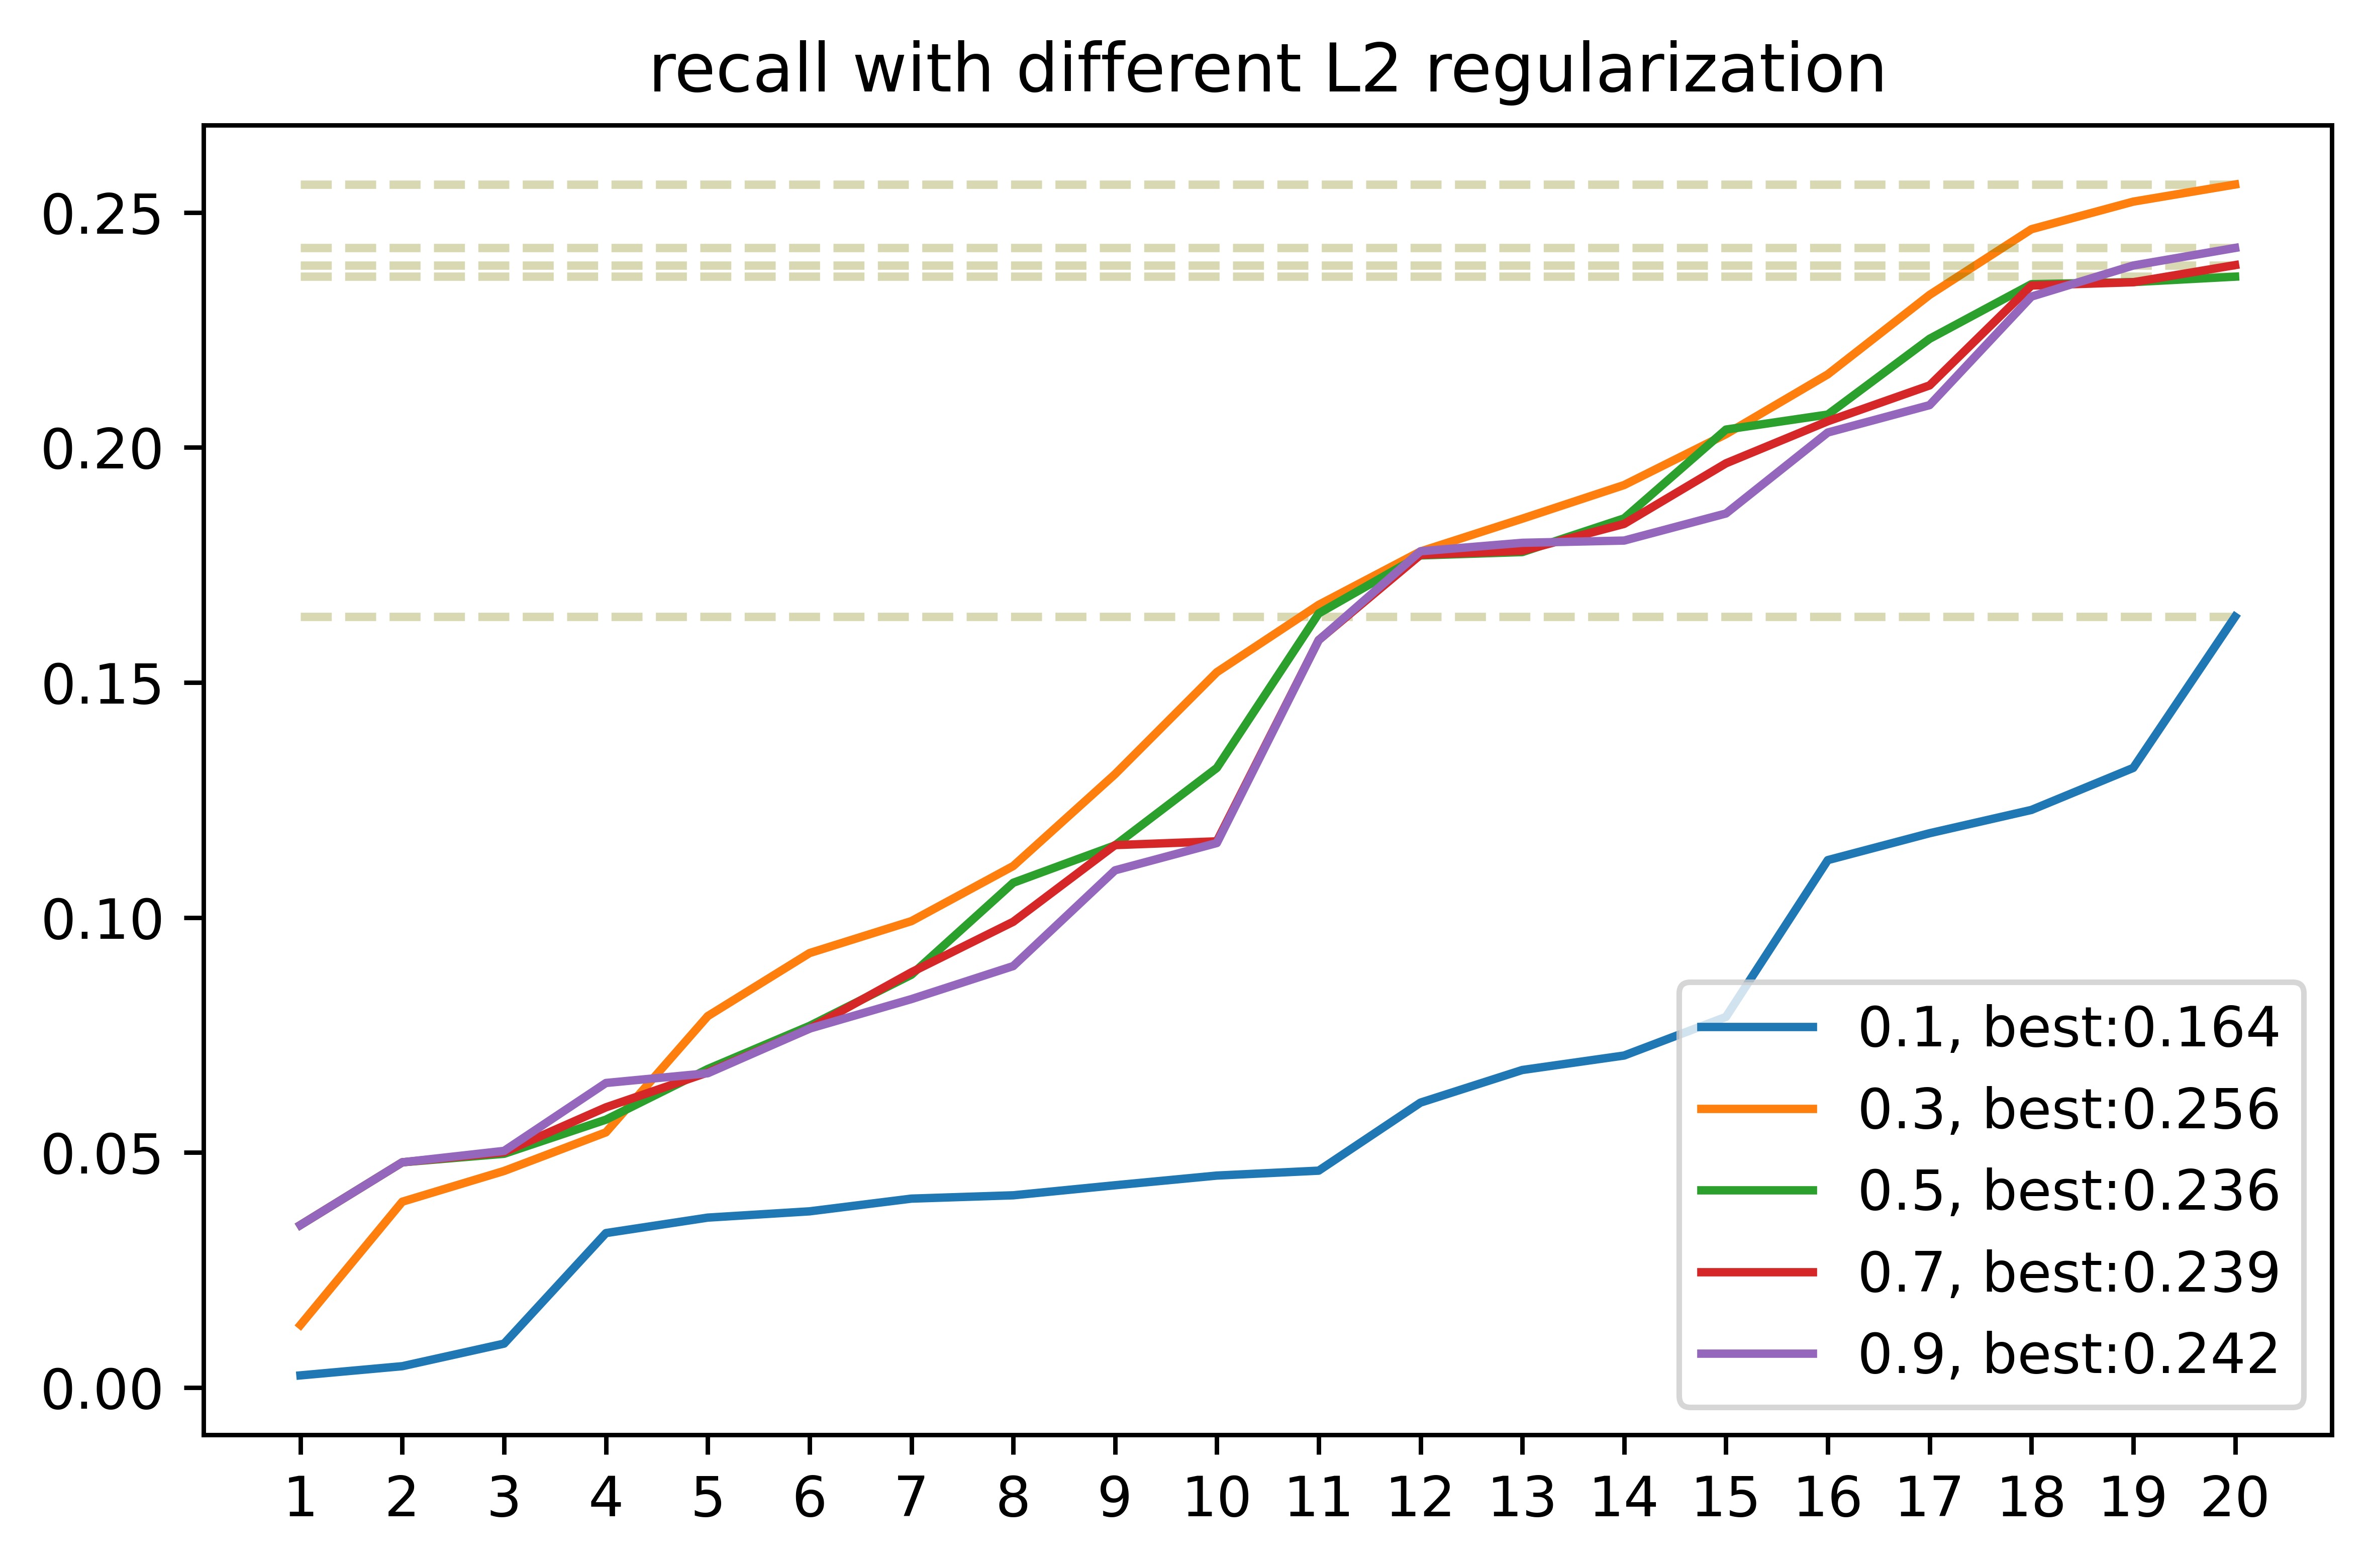

In [10]:
recalls = []
for l2 in  [0.1,0.3,0.5,0.7,0.9]:
    sp=os.path.join(
        cbmf_savepath,"clustering",
        "cbmf_l2test",f"{int(l2*100)}"
    ) 
    recalls.append(
        loadjson(os.path.join(sp, "metrics","metrics.json"))['recall']
    )


plot_comparison(
    x= recalls,
    labels= [0.1,0.3,0.5,0.7,0.9],
    title="recall with different L2 regularization",
    savename=os.path.join(
        cbmf_savepath,"clustering",
        "cbmf_l2test","recall.jpg"
    )
)

#### Zoom-in top-k 

It sees like the best value of $\lambda = 0.9$ for factorization clustering-based cross domain coarse matrix 
for our dataset

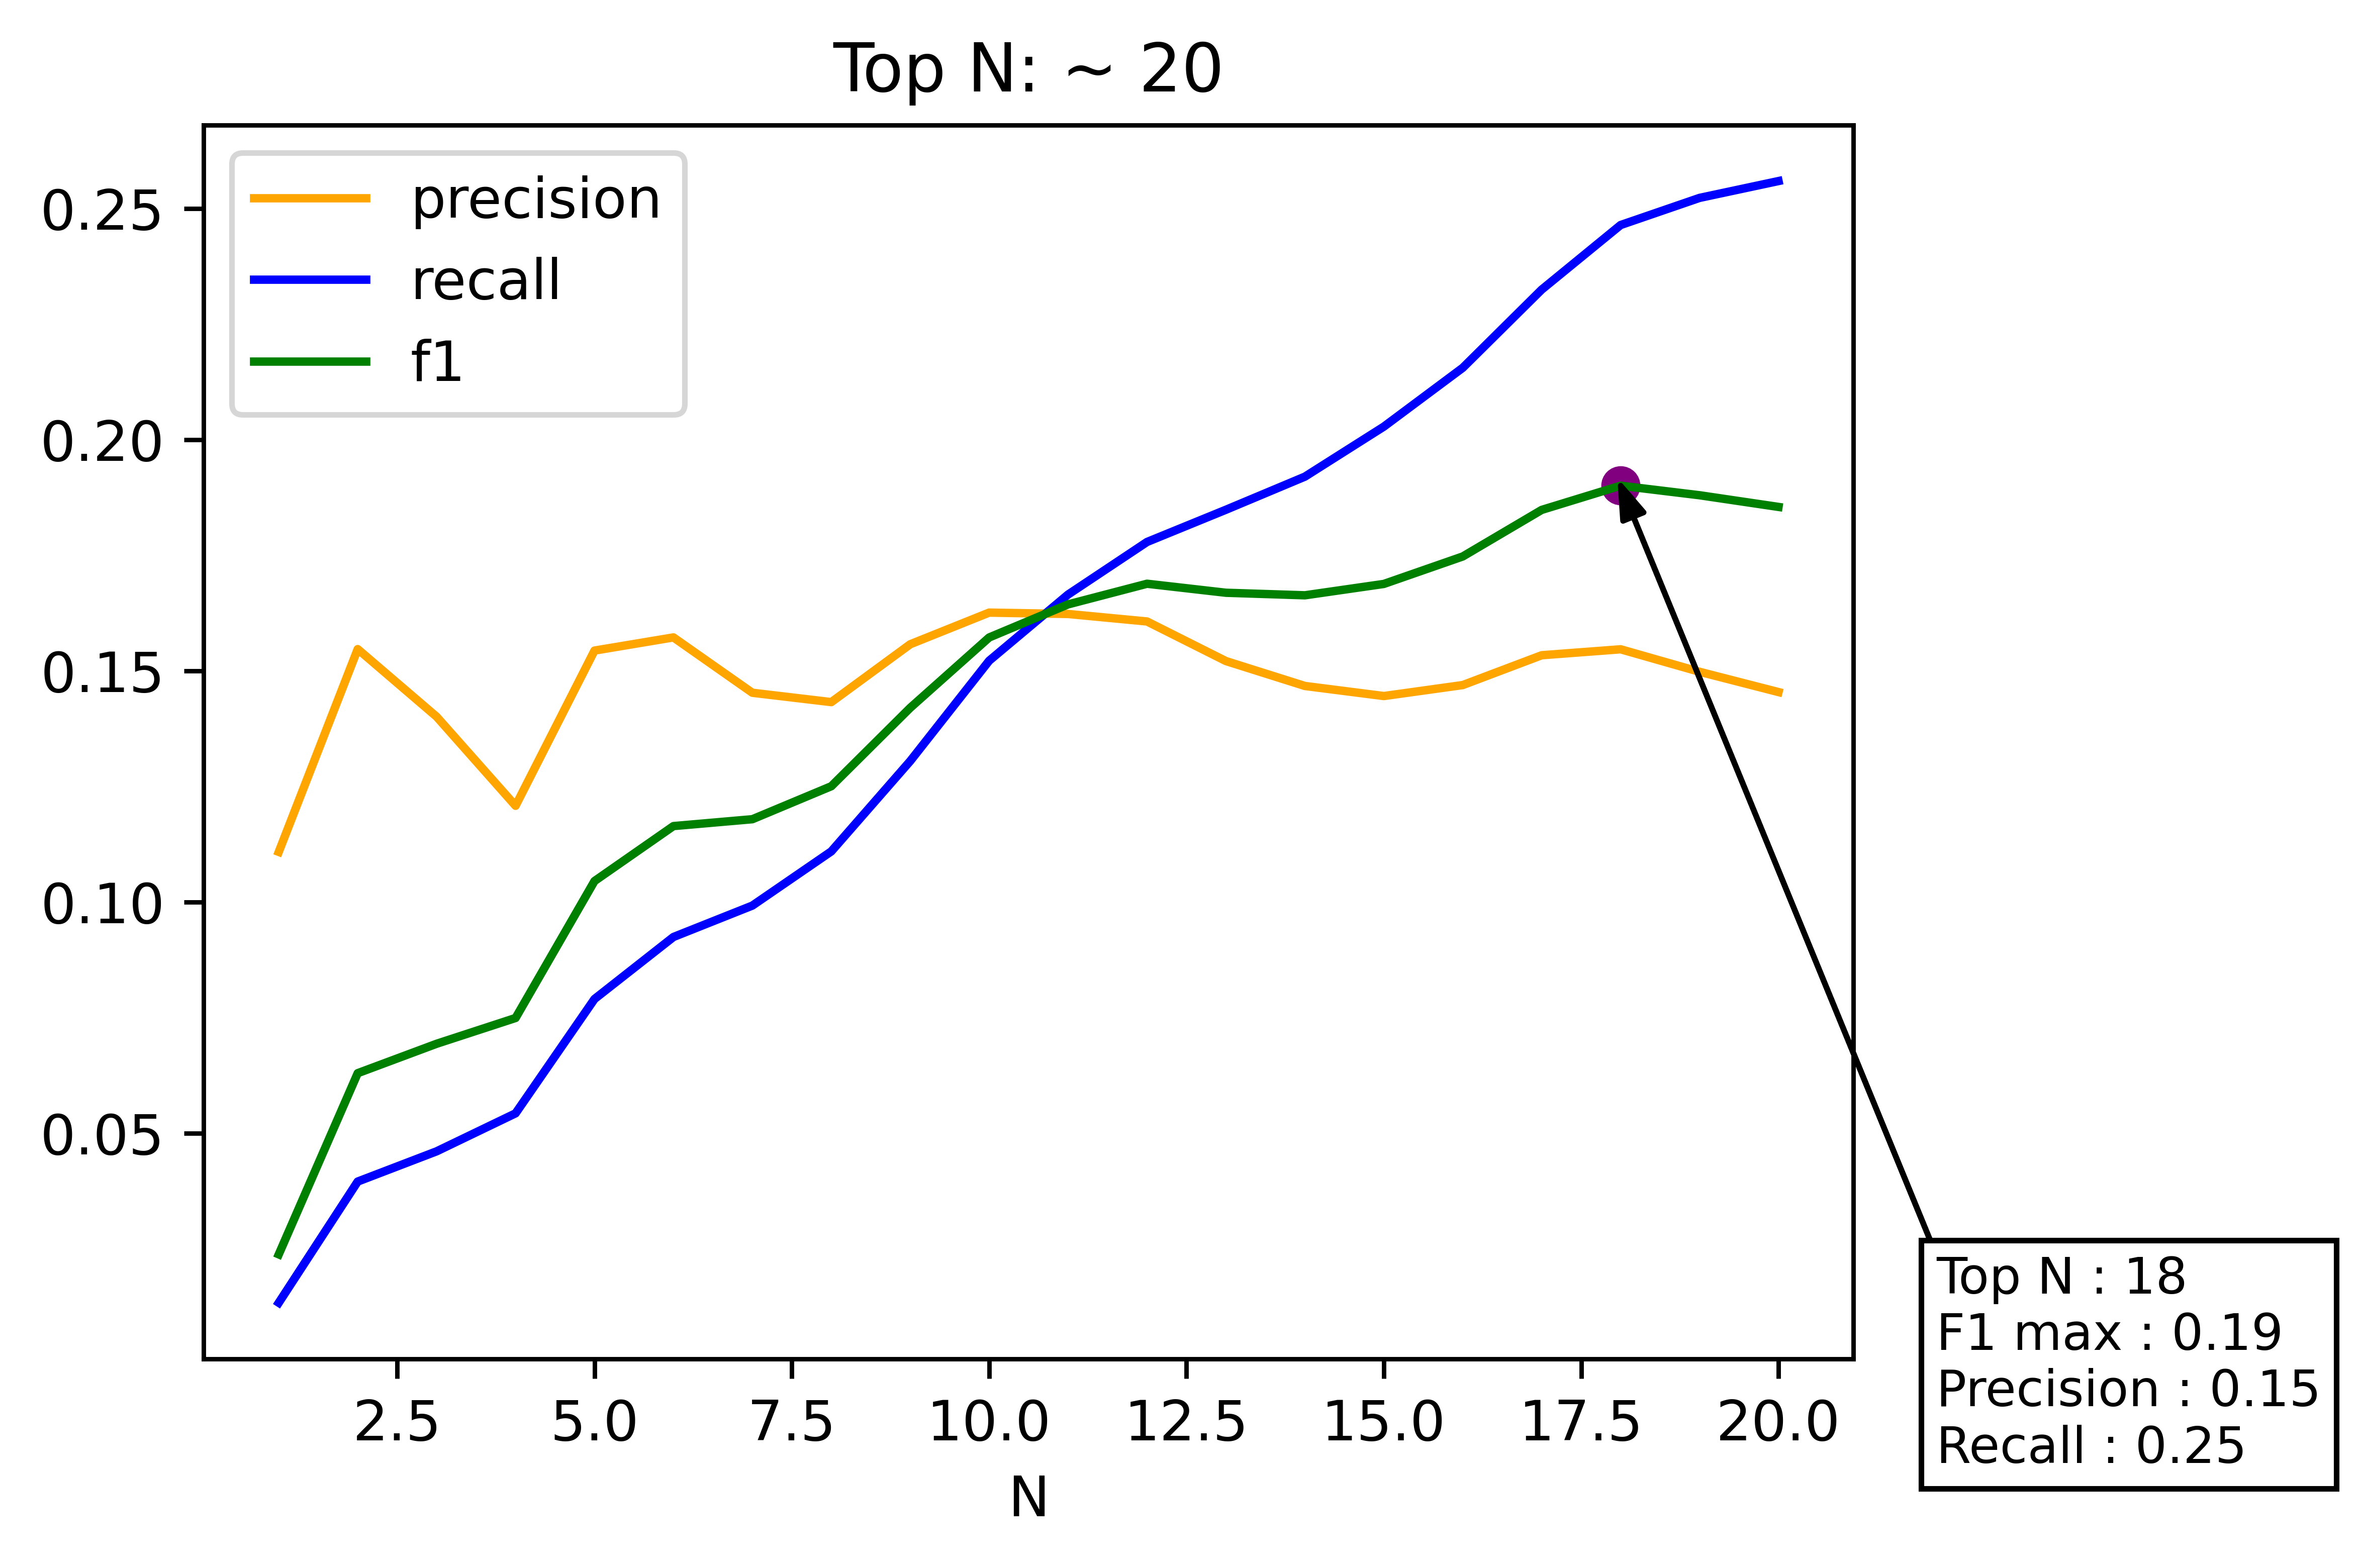

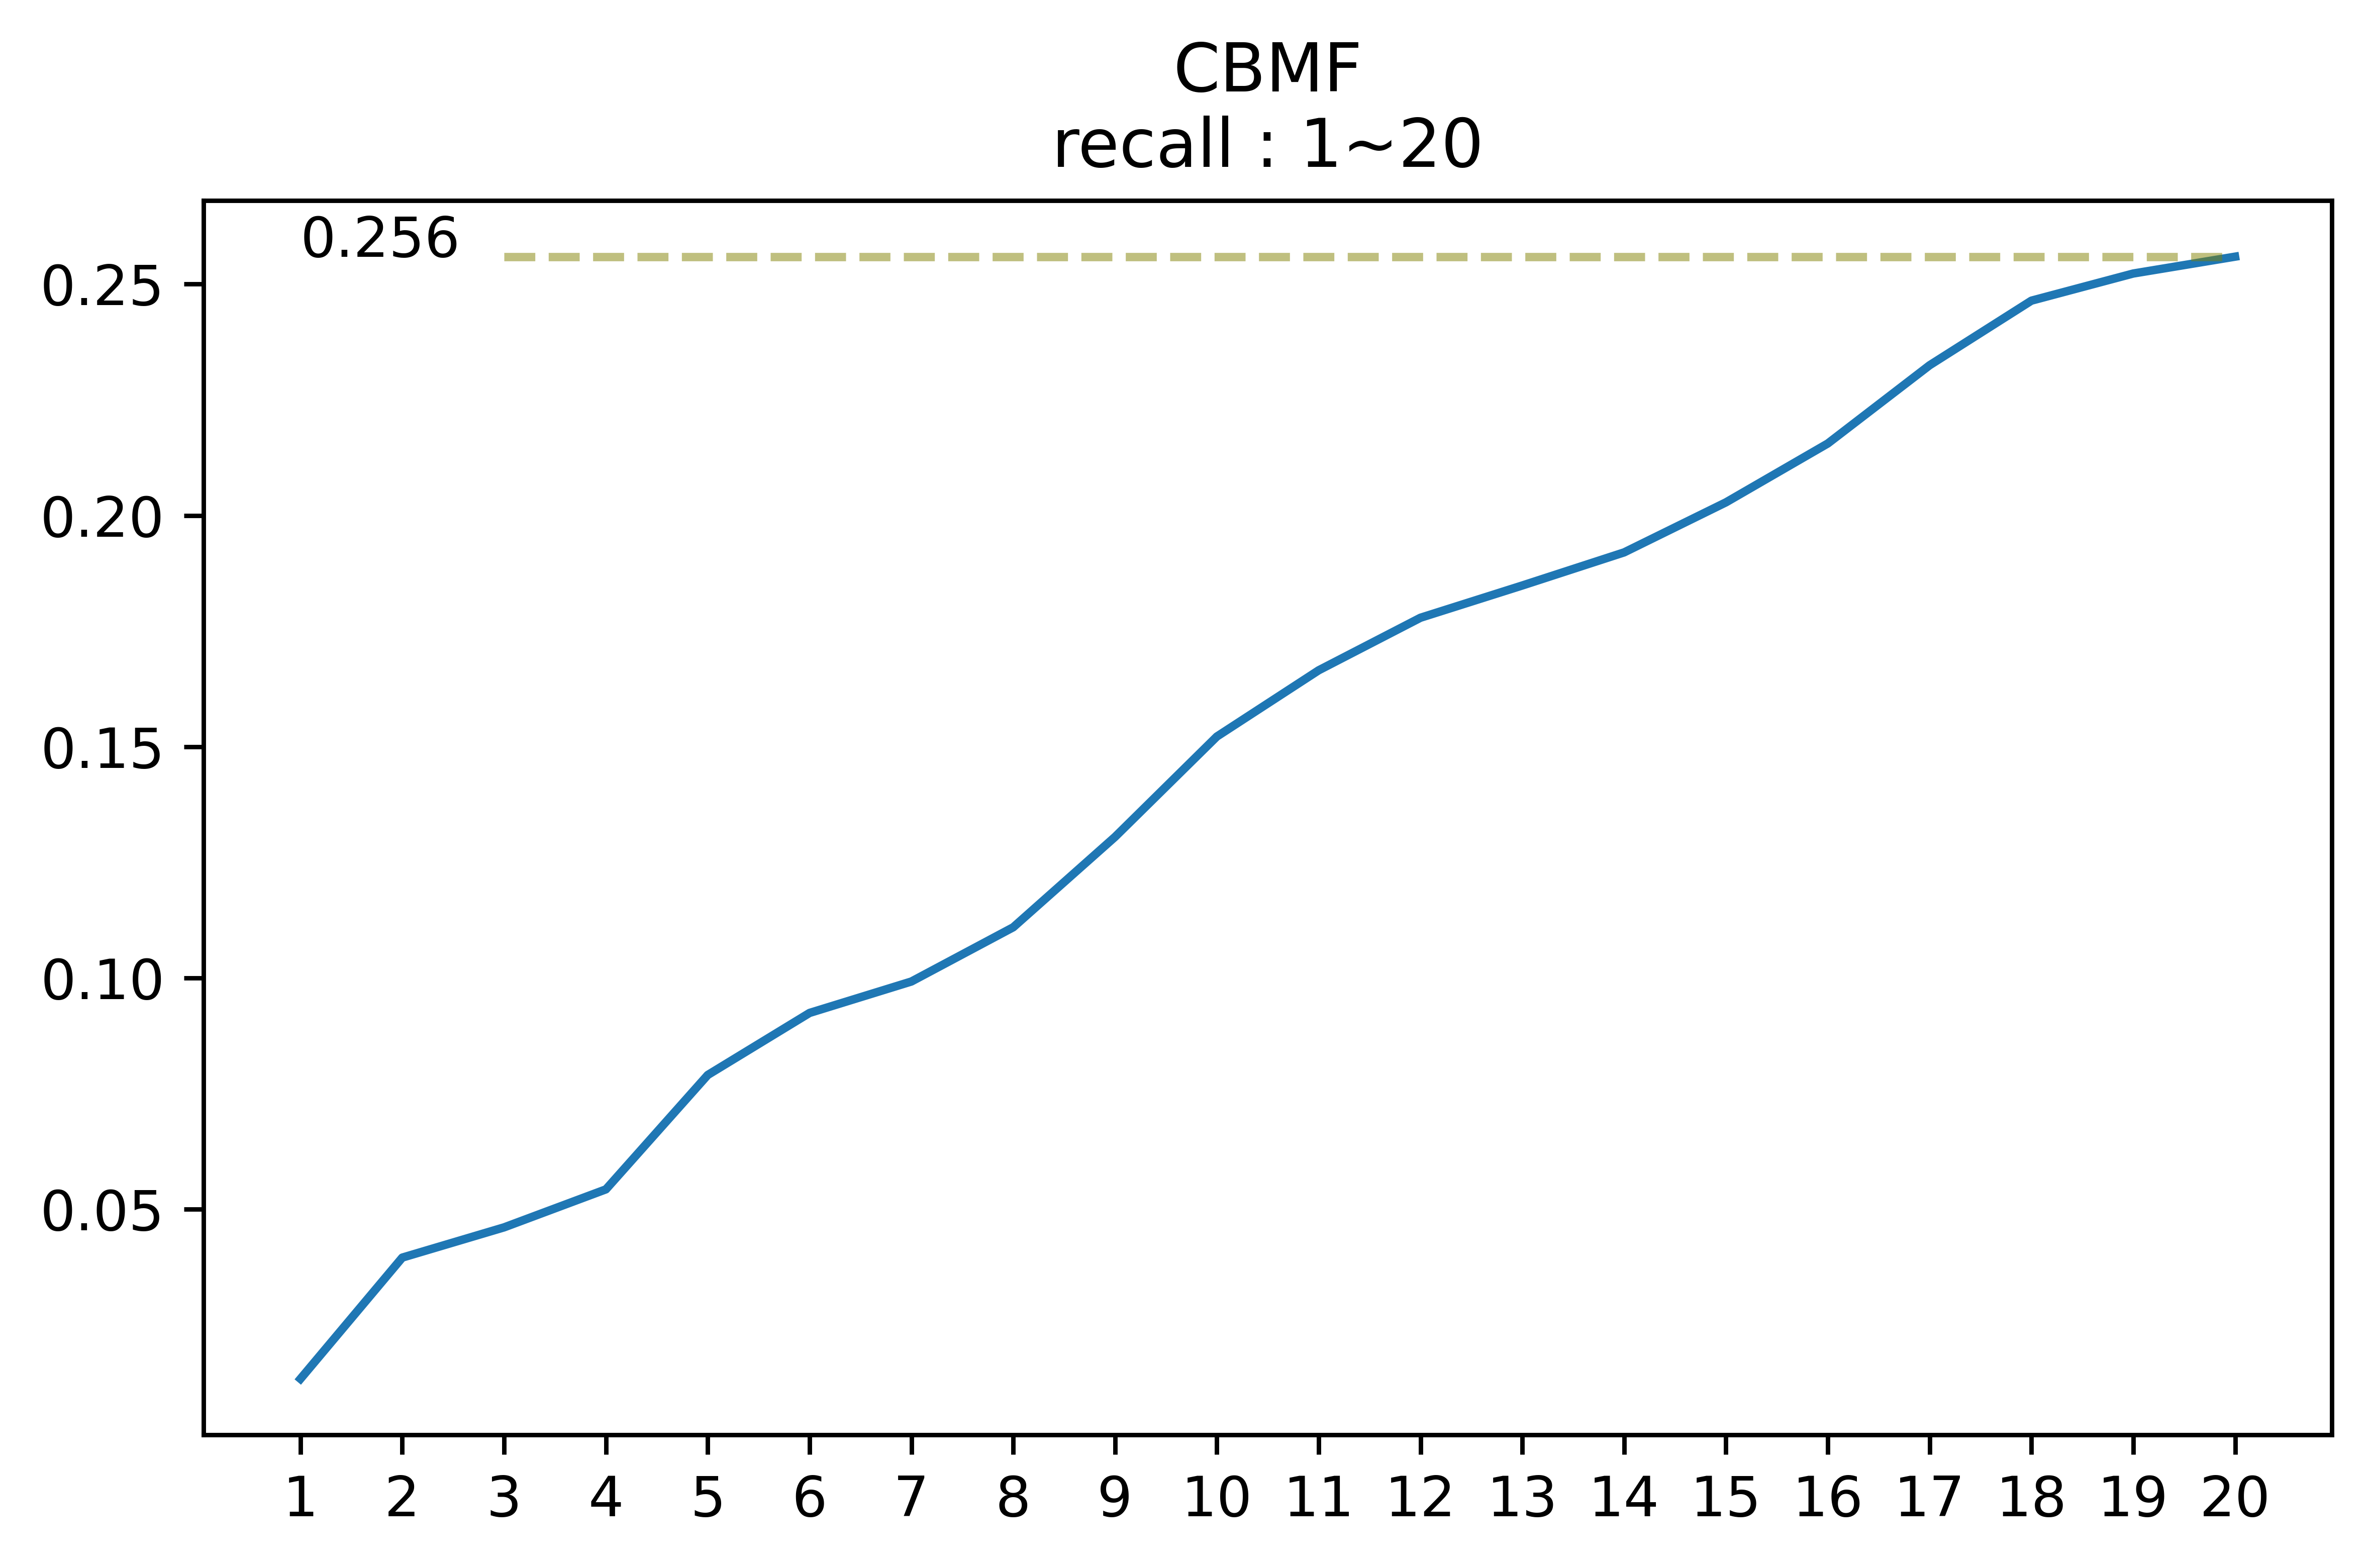

In [15]:

topk = 20
metrics = loadjson(
    os.path.join(
        cbmf_savepath,"clustering","cbmf_l2test","30",
        "metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(
        cbmf_savepath,"clustering","metrics"
    ),
    title="CBMF",
    showinline=True
)

## Comparison

In [16]:
%autoreload
from RS.utils.plotutils import plot_comparison
cmp_topN = 20

In [17]:
recall_list = {
    "method":[],
    "recall":[]
}
metric_path = os.path.join("metrics", "metrics.json")

In [18]:
popular_metrics = loadjson(
    os.path.join("result", "popular",metric_path)
)
commoncourse_metric = loadjson(
    os.path.join("result", "commoncourse",metric_path)
)
CrossMF_metric = loadjson(
    os.path.join("result", "CBMF" ,"nonclustering","normalize",metric_path)
)
CBMF_metric = loadjson(
    os.path.join(
        "result", "CBMF","clustering",
        "cbmf_l2test","30", metric_path
    )
)

recall_list['method'] = ['popular','commoncourse', 'CrossMF',"CBMF"]
recall_list['recall'] = [
    popular_metrics['recall'][:cmp_topN],
    commoncourse_metric['recall'][:cmp_topN], 
    CrossMF_metric['recall'][:cmp_topN],
    CBMF_metric['recall'][:cmp_topN]
]

result/Comparsion_recall.jpg


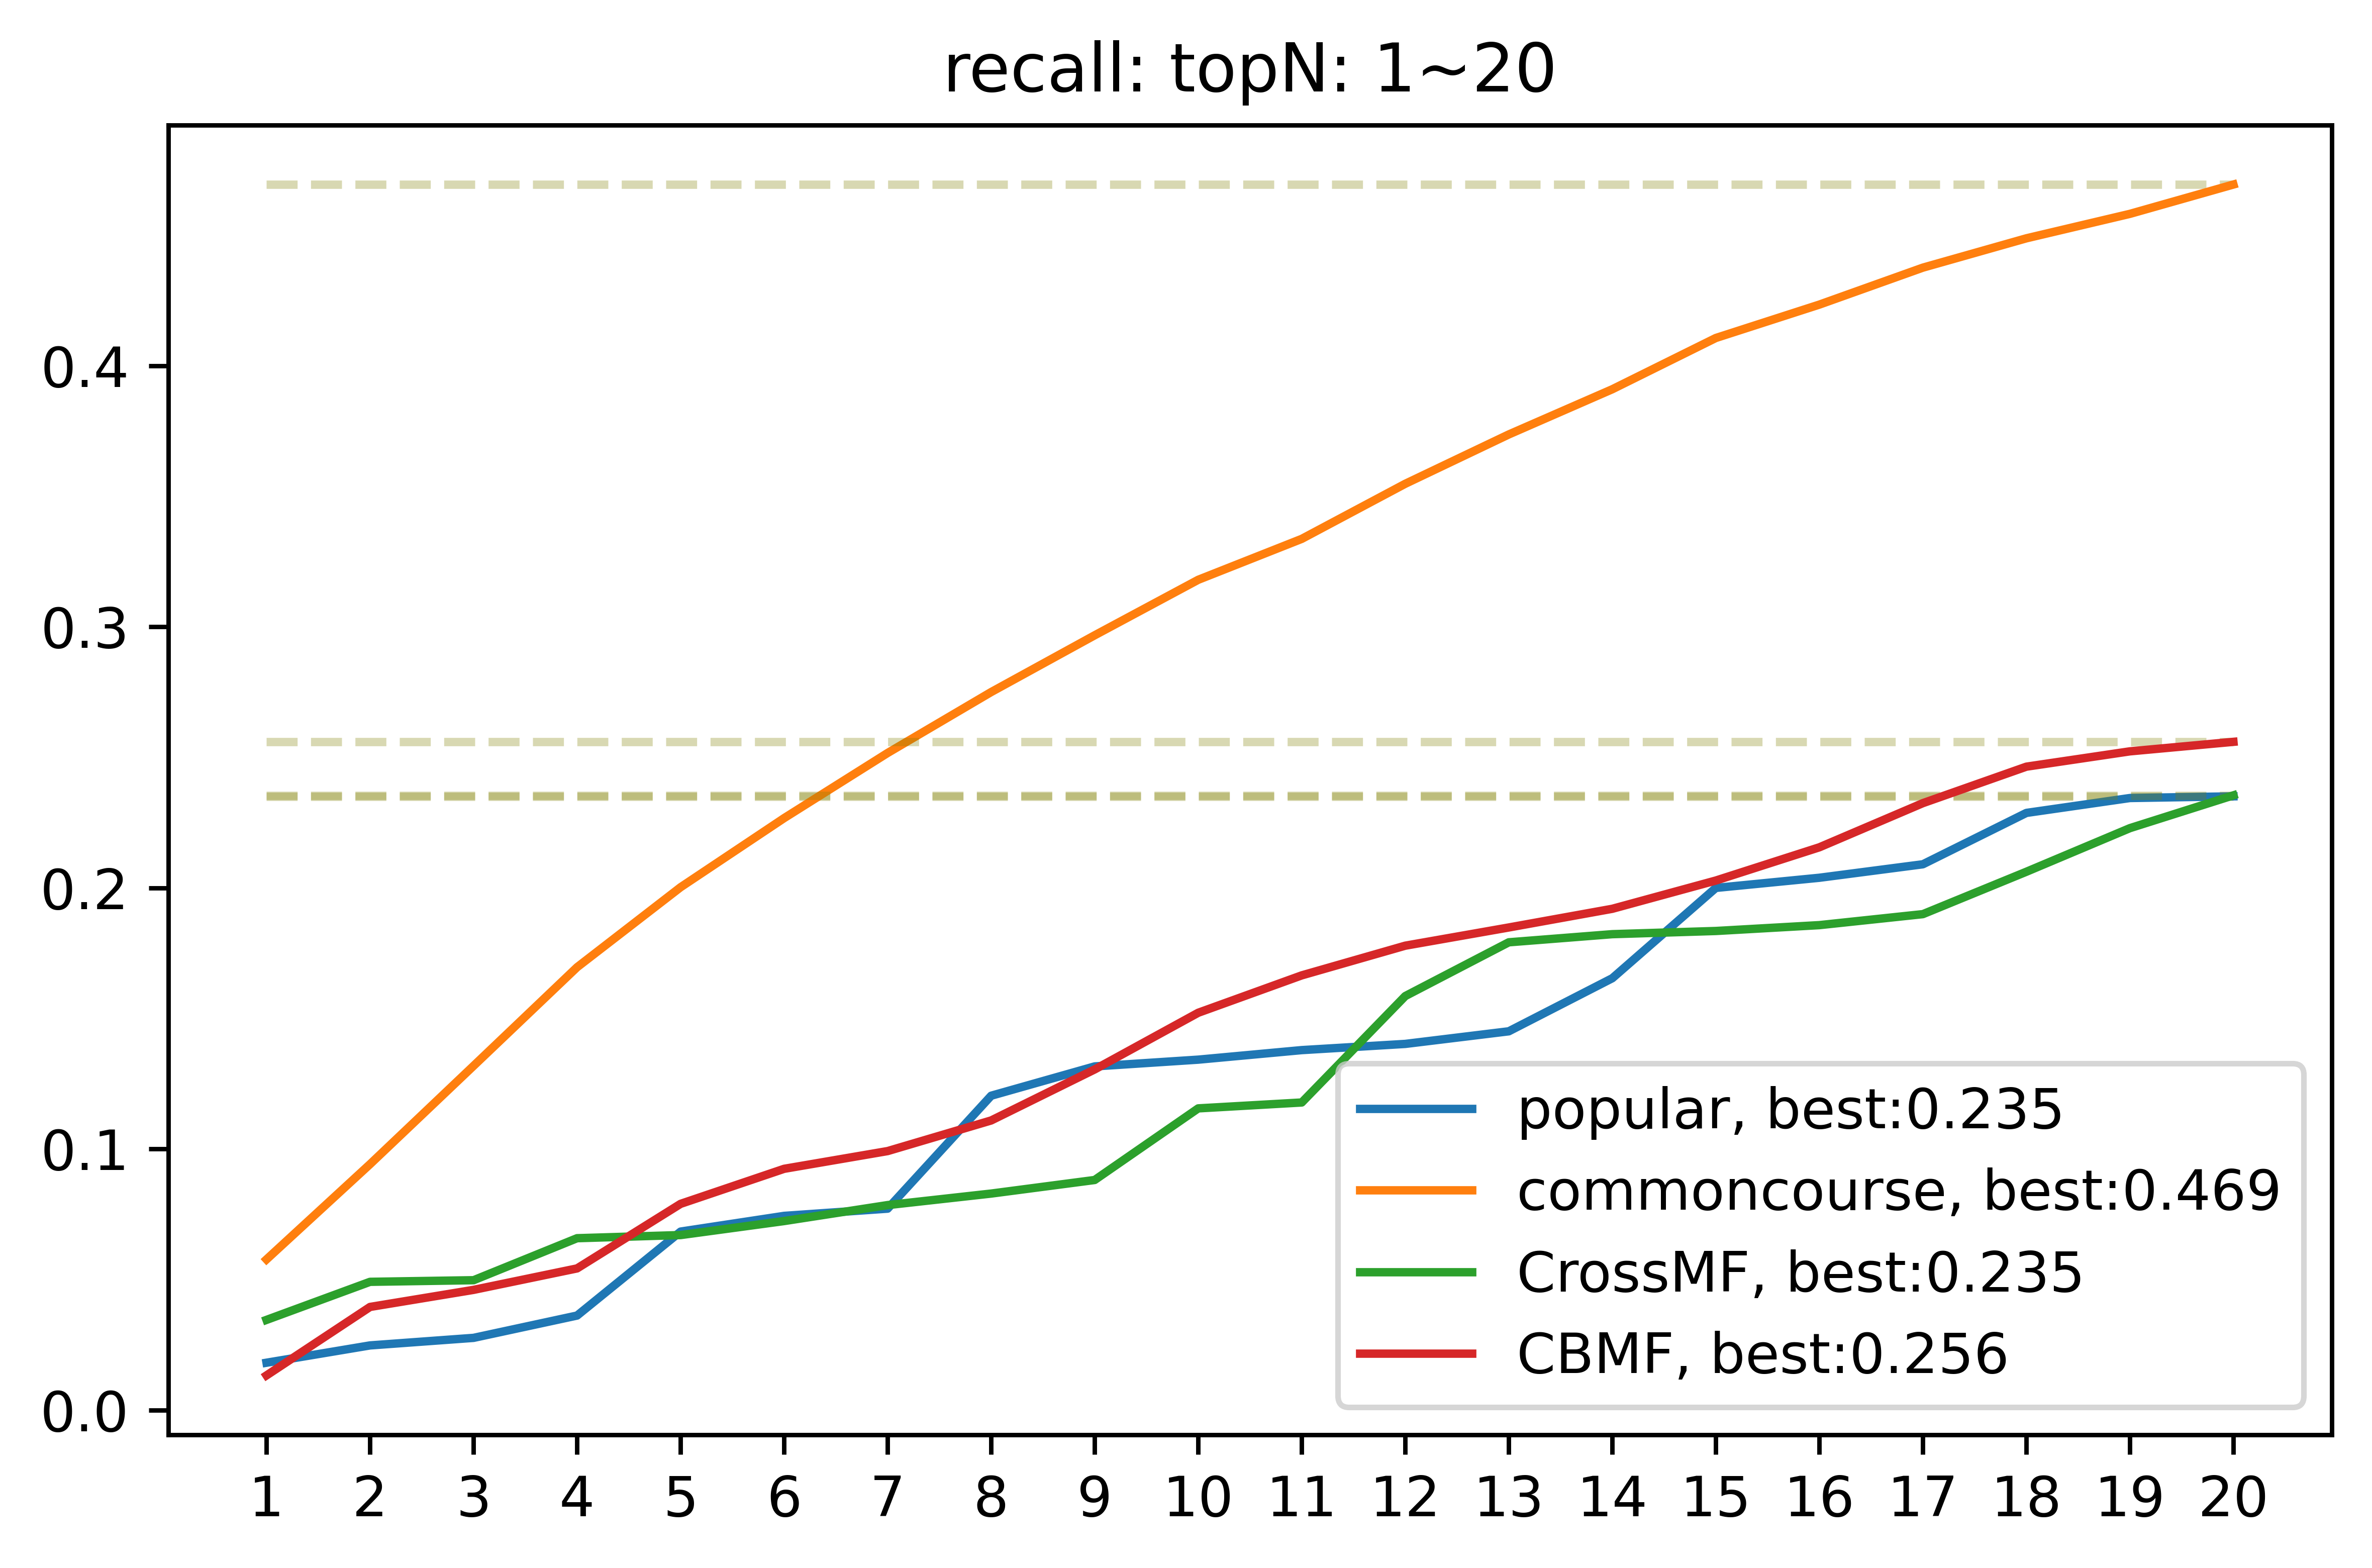

In [19]:
plot_comparison(
    x = recall_list['recall'],
    labels=recall_list['method'],
    savename=os.path.join("result", "Comparsion_recall.jpg"),
    title=f"recall: topN: 1~{cmp_topN}",
    showinline=True
)